# 0.0. IMPORTS

In [41]:
import pickle 
import math
import numpy  as np
import pandas as pd
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import random 
import tabulate
import requests

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from tabulate              import tabulate
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )
pd.options.display.float_format = '{:.2f}'.format

## 0.1 - Funções Auxiliares

In [42]:
def cross_validation(training, kfold, model, model_name, verbose=False): 
    
    mae_list = []
    mape_list = [] 
    rmse_list = [] 

    
    for k in reversed(range(1, kfold + 1)): 
        
        if verbose: 
            print(f'\nKfold Number: {k}')
        
        #definir limites de validação
        
        validation_start_date = training['date'].max() - datetime.timedelta(days = k * 6 * 7 )
        validation_end_date = training['date'].max() - datetime.timedelta(days = (k-1) * 6 * 7 )
        
        #filtrar o dataset em validation e treinamento 
        
        training = training[training['date'] < validation_start_date ]
        validation = training[(training['date'] >= validation_start_date) & (training['date'] < validation_end_date)]
        
        #criar x_training e y_training 
        
        x_training = training.drop(['sales', 'date'], axis = 1) 
        
        y_training = training['sales'] 
        
        #criar x_validation e y_validation 
        
        x_validation = validation.drop(['sales', 'date'], axis = 1)
        y_validation = validation['sales']
        
        #treinar modelo 
        
        m = model.fit(x_training, y_training)
        
        #predição 
        
        yhat = m.predict(x_validation)
        
        #performance 
        
        performance = ml_error(model_name, np.expm1(y_validation), np.expm1(yhat)) 
        
        mae_list.append(performance['MAE']) 
        mape_list.append(performance['MAPE'])
        rmse_list.append(performance['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name, 
                    'MAE CV': round(mae_list.mean(), 2).astype(str) + '+/-' + round(mae_list.std(), 2).astype(str)}, 
                    {'MAPE CV': round(mape_list.mean(), 2).astype(str) + '+/-' + round(mape_list.std(), 2).astype(str)}, 
                    {'RMSE CV': round(rmse_list.mean(), 2).astype(str) + '+/-' + round(rmse_list.std(), 2).astype(str)}, index = [0])

def mean_percentage_error(y, yhat): 
    return np.mean(((y - yhat) / y ))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y ))

def ml_error(model_name, y, yhat): 
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name, 
                        'MAE': mae, 
                        'MAPE': mape, 
                        'RSME': rmse},  
                       index = [0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v(x, y): 
    
    cm = pd.crosstab(x, y).values 
    
    r, k = cm.shape  
    
    n = cm.sum() 

    chi2 = ss.chi2_contingency(cm)[0]  
    phi2 = chi2/n
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1) 
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( phi2corr / min(kcorr-1, rcorr-1))

In [43]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Carregando Dados

In [44]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) 
df_store_raw = pd.read_csv('data/store.csv', low_memory = False )

#mesclar os dois csvs: 

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on = 'Store')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [45]:
df1 = df_raw.copy() 

In [90]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4,2015,0,31,2015,0,Jul,0


In [46]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [47]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 Dimensões da Base de Dados

In [48]:
print('Número de Linhas: {}'.format(df1.shape[0]))
print('Número de Colunas: {}'.format(df1.shape[1]))

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3 Tipos de Dados

In [35]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [22]:
#antes de tratamentos. 
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.4 Checar NA

In [24]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preencher valores NA

In [49]:
#alterando data para formato datetime 

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [50]:
df1['competition_distance'].max() 

#competition_distance 

#Na em uma distância de competidor provavelmente é porque não tem competidor próximo. Então eu coloco uma distância 
#muito maior do que a máxima distância para preencher os valores NaN, pois assumo que não tem competidor nas proximidades. 

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition open_since_month

#A presença de concorrência a partir de um momento no tempo influencia muito nas vendas. Pensando na importância, para utilizar
#essa coluna nos modelos, eu vou colocar a data das vendas na mesma, mesmo não fazendo sentido. Deixa-se algo mais lógico 
#para outro ciclo de solução, caso necessário.

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1) 

#promo interval - Certamente os NA referem-se a lojas que não participaram da promoção.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [39]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
653830,111,5,2013-11-22,7773,707,1,1,0,0,d,c,7890.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",Nov,0
23395,1096,6,2015-07-11,4475,517,1,0,0,0,a,c,1130.0,7.0,2015.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",Jul,0
5123,664,1,2015-07-27,6963,763,1,1,0,1,d,c,1680.0,10.0,2005.0,0,31.0,2015.0,0,Jul,0
64067,513,4,2015-06-04,19352,2110,1,1,0,0,a,a,400.0,8.0,2013.0,0,23.0,2015.0,0,Jun,0
434747,683,6,2014-06-07,6119,588,1,0,0,0,a,a,2850.0,7.0,2014.0,0,23.0,2014.0,0,Jun,0


## 1.6 Alterando Tipos

In [40]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [51]:
#float para int 

#ccompetição desde 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2 desde 
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [42]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Estatística Descritiva

## 1.7.1 Atributos Numéricos

In [52]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [53]:
#Tendência Central - média, mediana

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersão - desvio padrão, min, max, range, skew, kurtosis 

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() 
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [45]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


## 1.7.2 Atributos Categóricos

In [23]:
cat_attributes.apply(lambda x: x.nunique())

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

In [54]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)] 
#tirando os dias que não teve venda, eu consigo analistar o boxplot melhor 

<Axes: xlabel='assortment', ylabel='sales'>

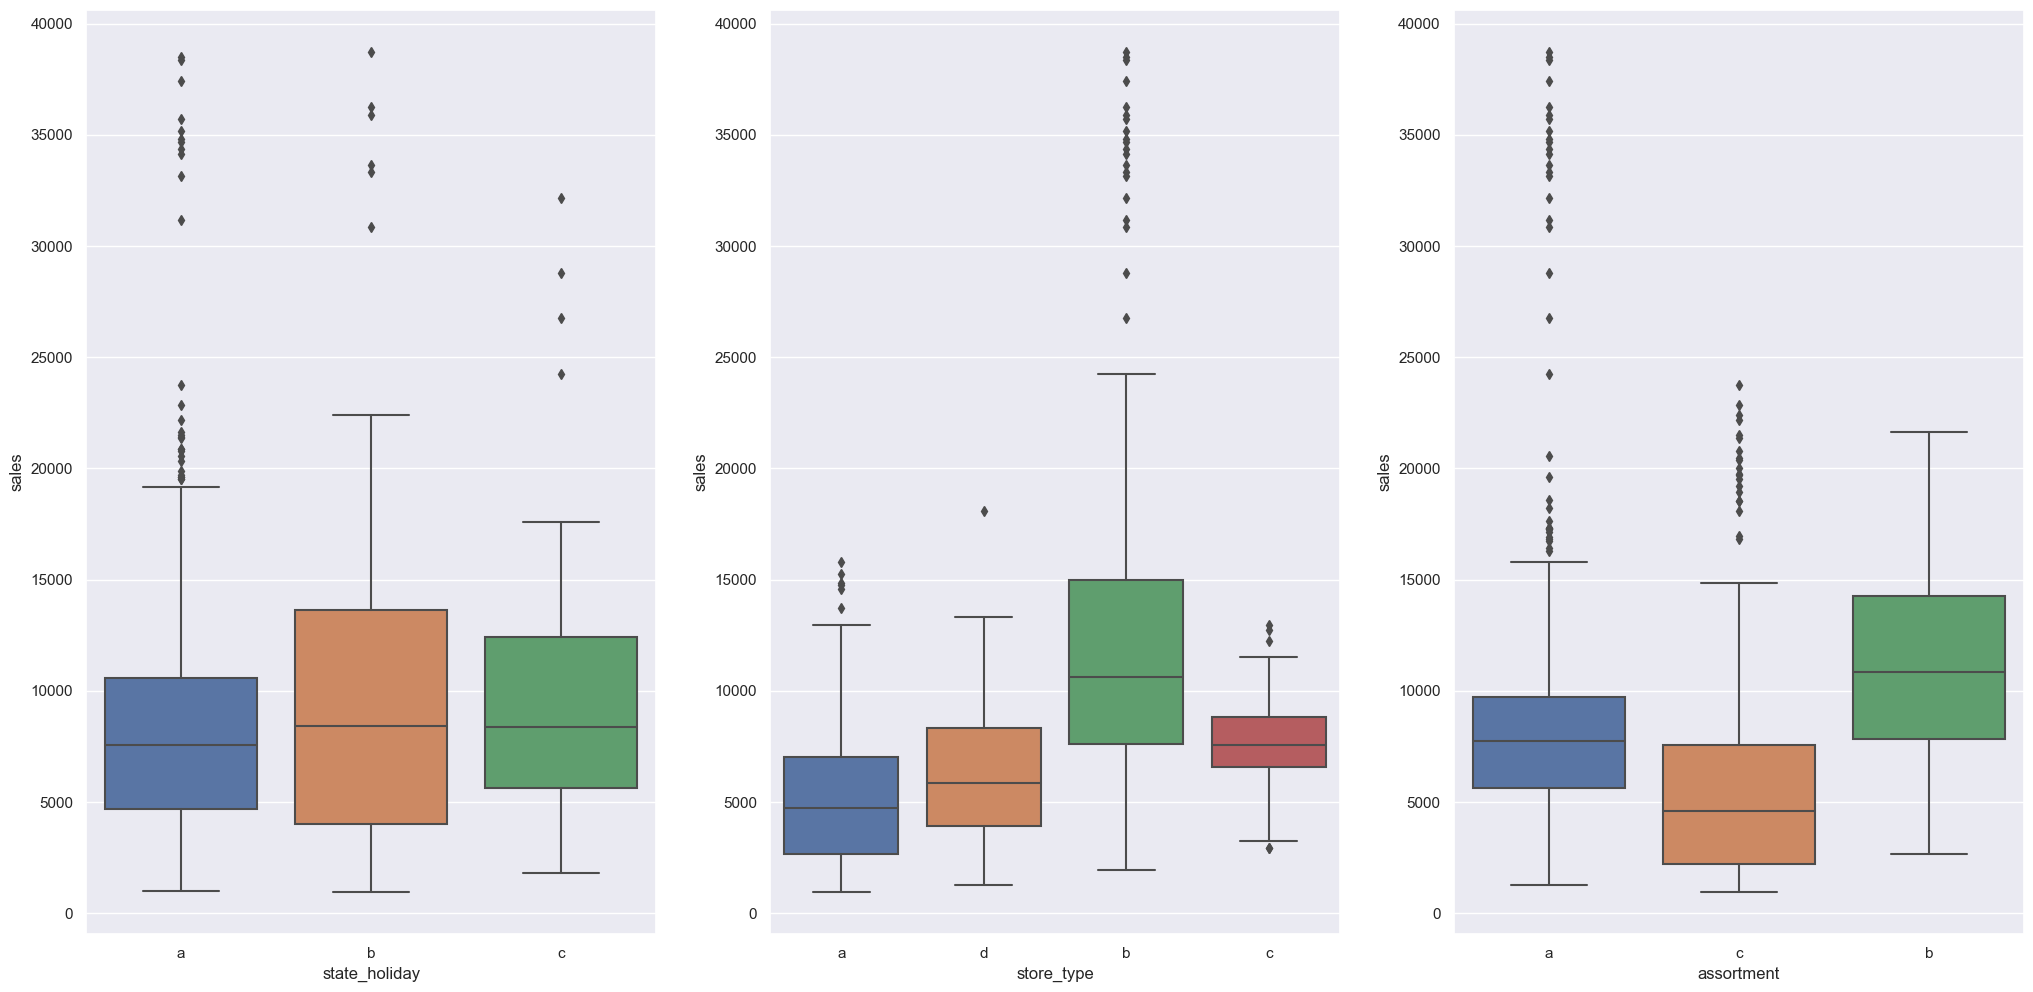

In [25]:
plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y='sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x= 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3) 
sns.boxplot(x= 'assortment', y = 'sales', data = aux1)

# 2.0. PASSO 2 - FEATURE ENGINEERING

## 2.1. Mapa Mental de Hipoteses

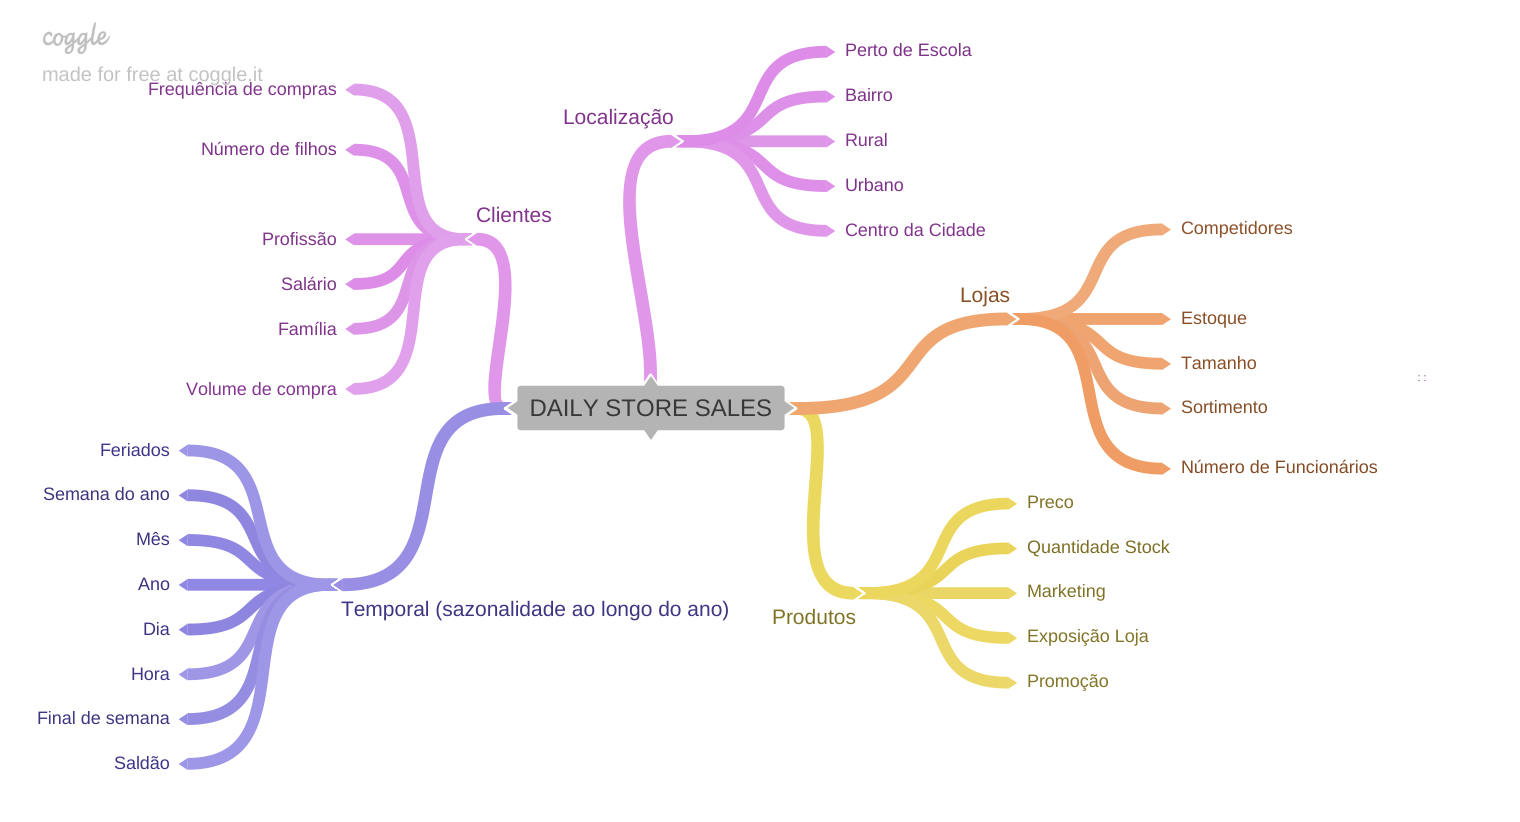

In [26]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação das Hipóteses

### 2.1.1 Hipóteses Loja 

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [55]:
#derivando features a partir das variáveis originais. 

df2 = df1.copy() 

#ano
df2['year'] = df2['date'].dt.year 

#mês
df2['month'] = df2['date'].dt.month

#dia 
df2['day'] = df2['date'].dt.day 

#dia da semana
df2['week_of_year'] = df2['date'].dt.weekofyear
 
#semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competição desde

#Como estão separadas em colunas de dia, mês e ano, optei por uní-las em uma data só, colocando o dia como 1 para pegar o mês como um todo, desde o primeiro dia. 

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)


df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int) 

#promo desde 

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int ) #quantidade de semanas entre a data registrada de vendas e o período de começo da promo2. 

#classificação
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#feriado estadual
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [56]:
df3 = df2.copy()

# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

## 3.1 Filtragem de linhas

In [57]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] 

#só tenho vendas quando a loja estiver aberta. 

## 3.2 Seleção das Colunas

In [58]:
#Deleto a coluna costumers pois como eu não consigo prever o número de clientes no momento da predição, deleto essa coluna. 

#De acordo com a filtragem da célula acima, a coluna open é sempre 1. 

#As outras colunas abaixo são auxiliares. 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [20]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [59]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

<Axes: xlabel='sales', ylabel='Count'>

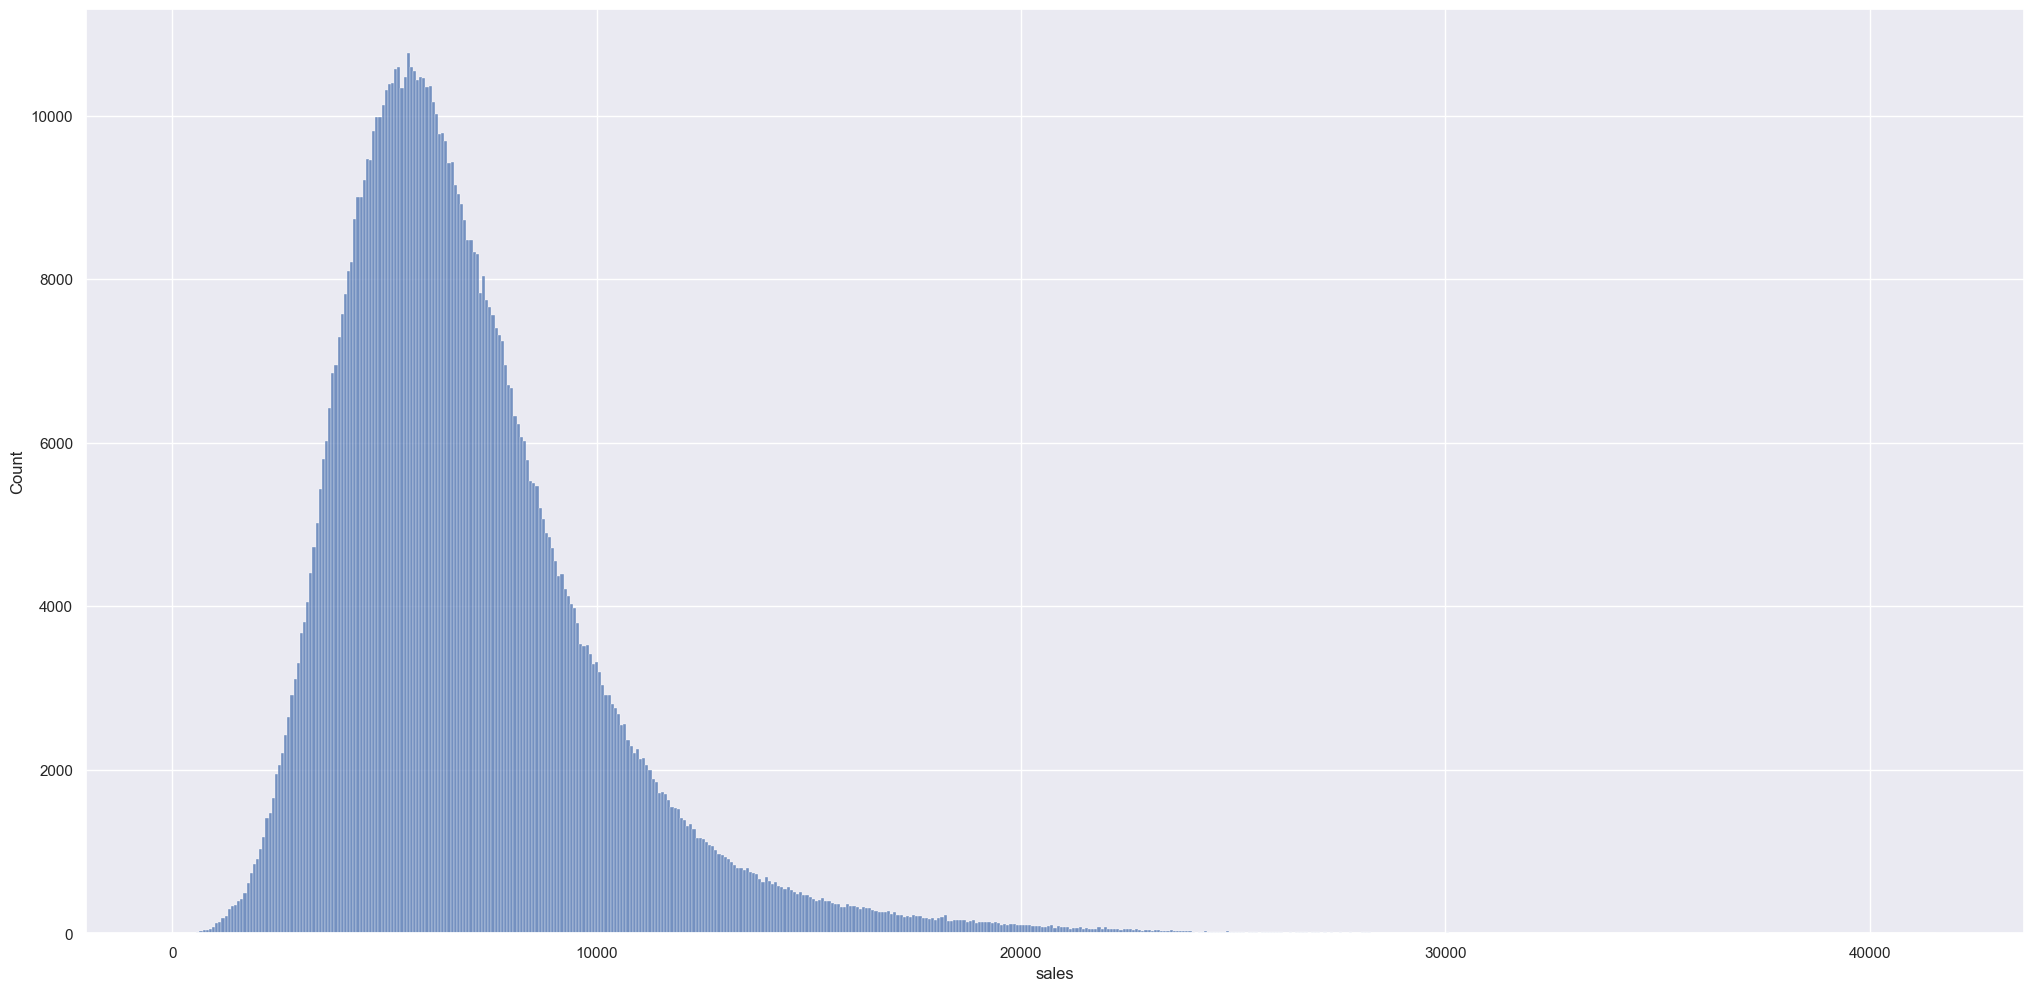

In [34]:
sns.histplot(df4['sales'])

### 4.1.2 Variável Numérica

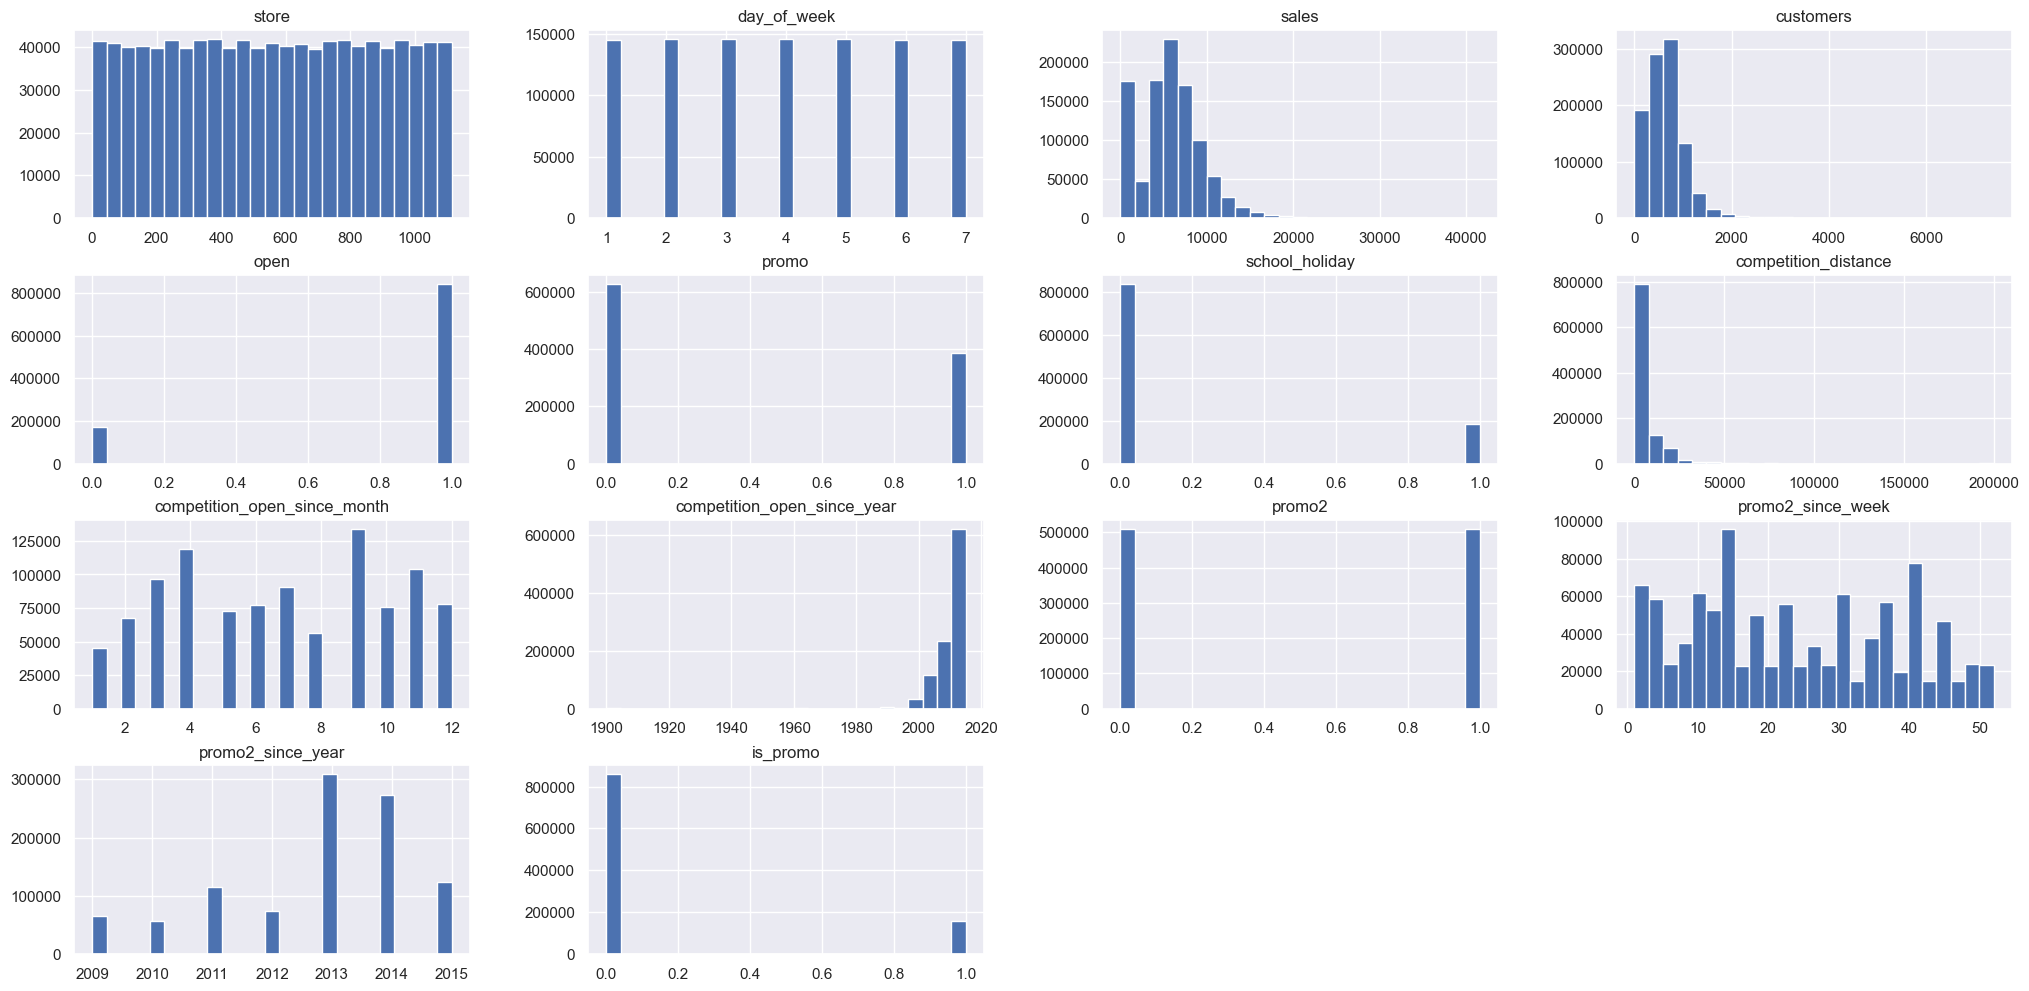

In [136]:
num_attributes.hist(bins = 25);

### 4.1.3 Variável Categórica

In [31]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

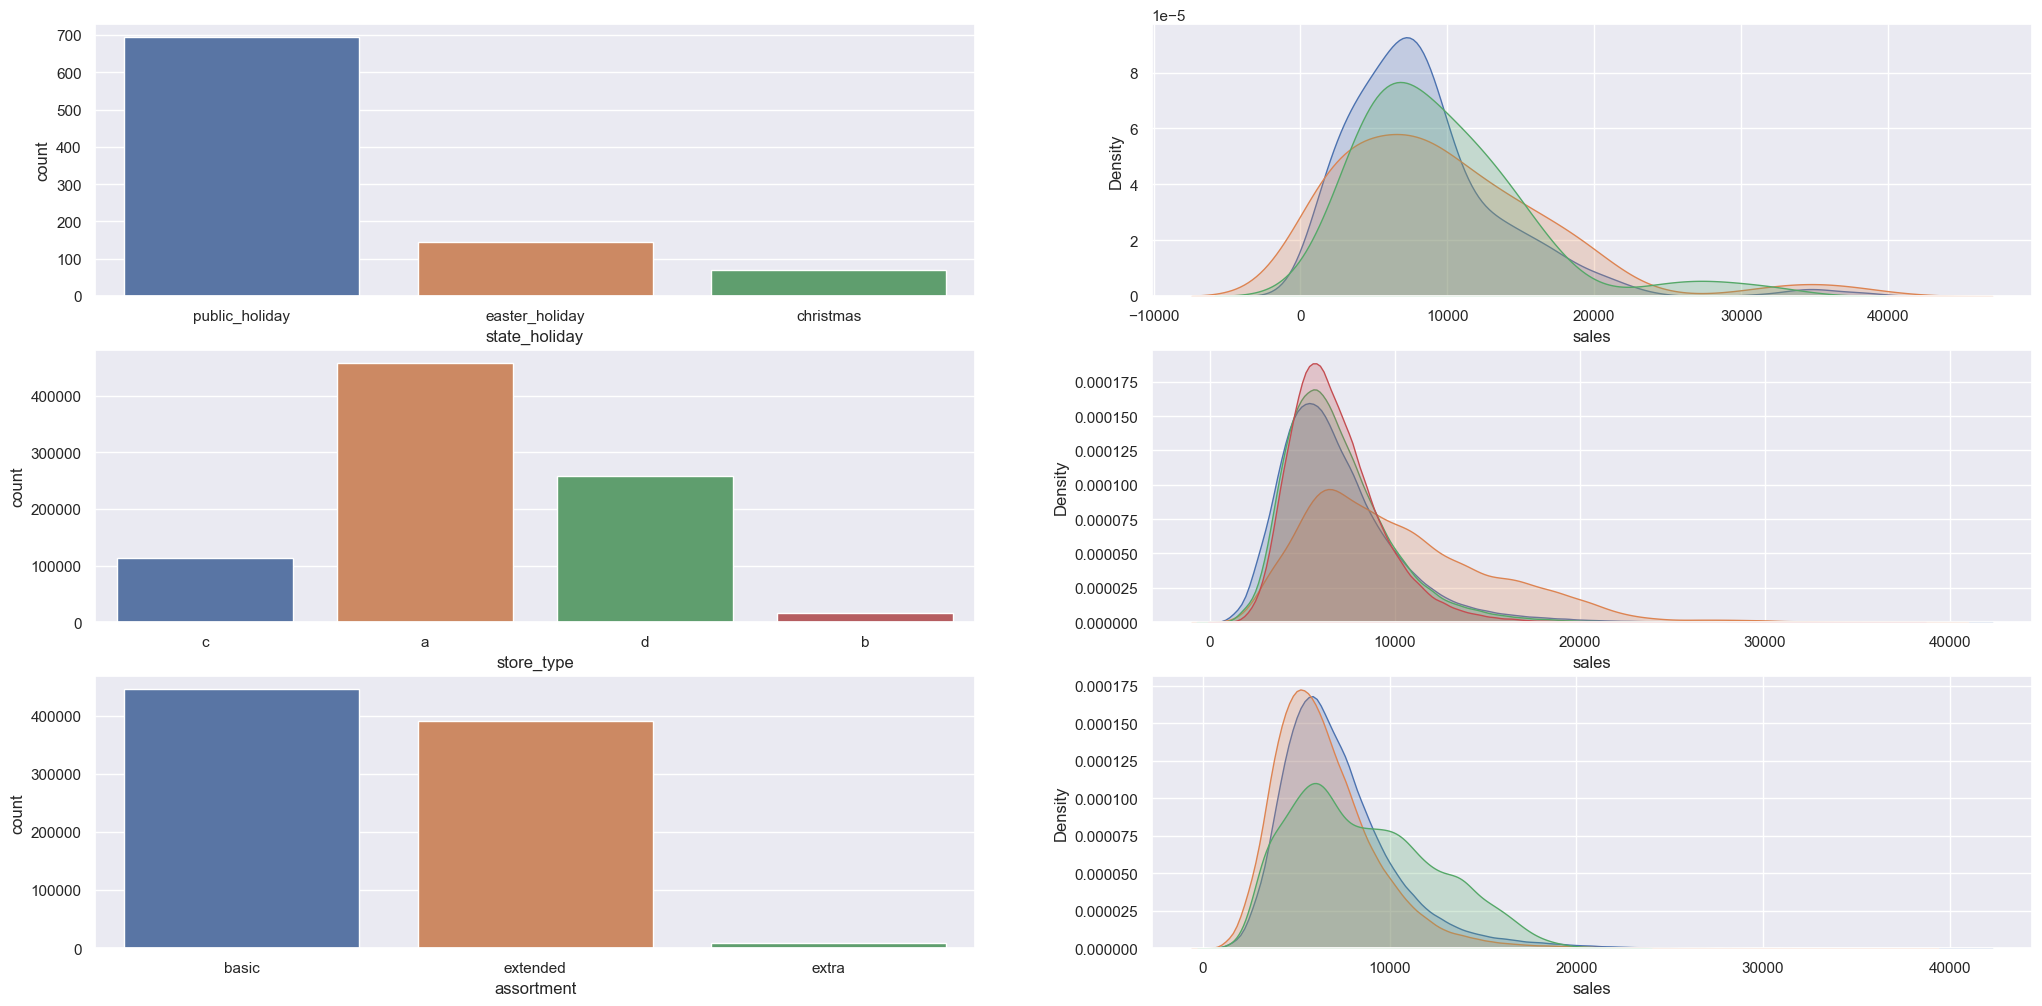

In [36]:
# feriado estadual
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# tipo de loja 
plt.subplot( 3, 2, 3 )
sns.countplot(x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# classificação 
plt.subplot( 3, 2, 5 )
sns.countplot(x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Análise Bivariada

### h1. Lojas com maior variedade de produto deveriam vender mais.
Falso! Lojas com maior variedade de produto vendem menos

In [75]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

In [60]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

<Axes: xlabel='year_week'>

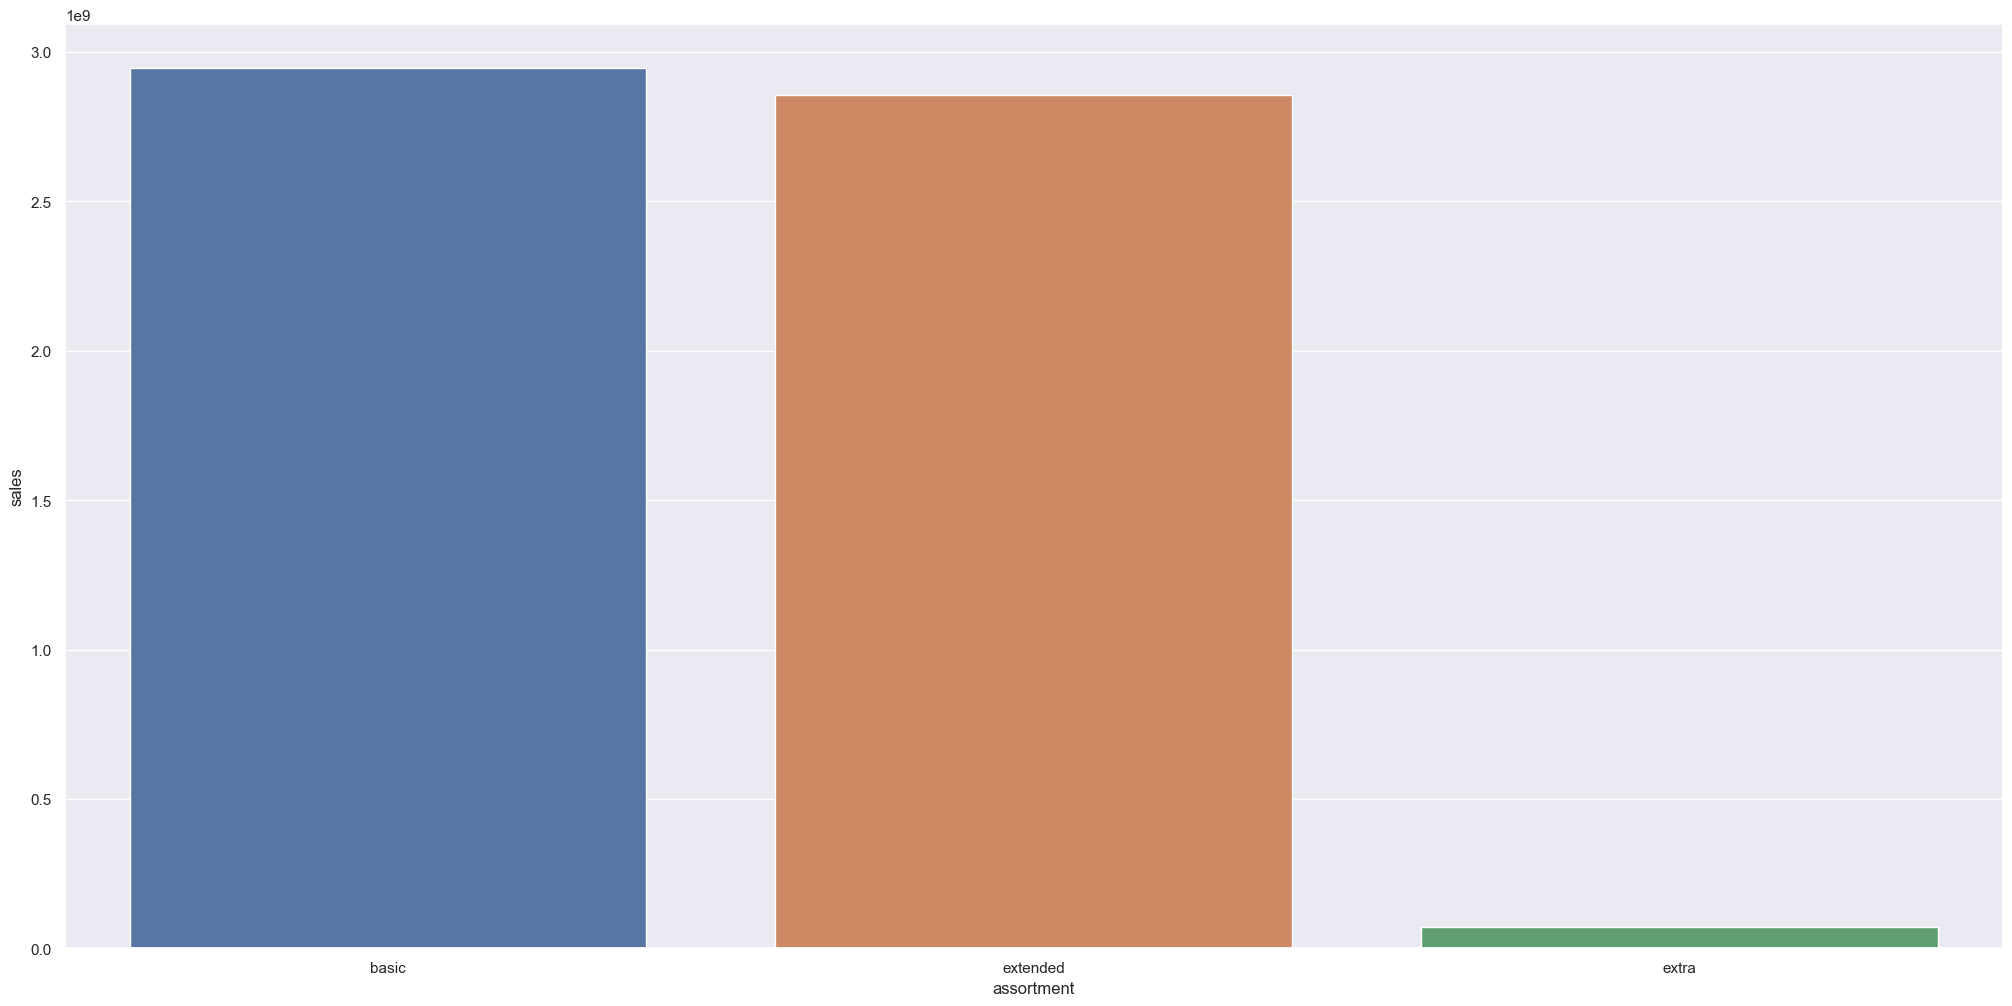

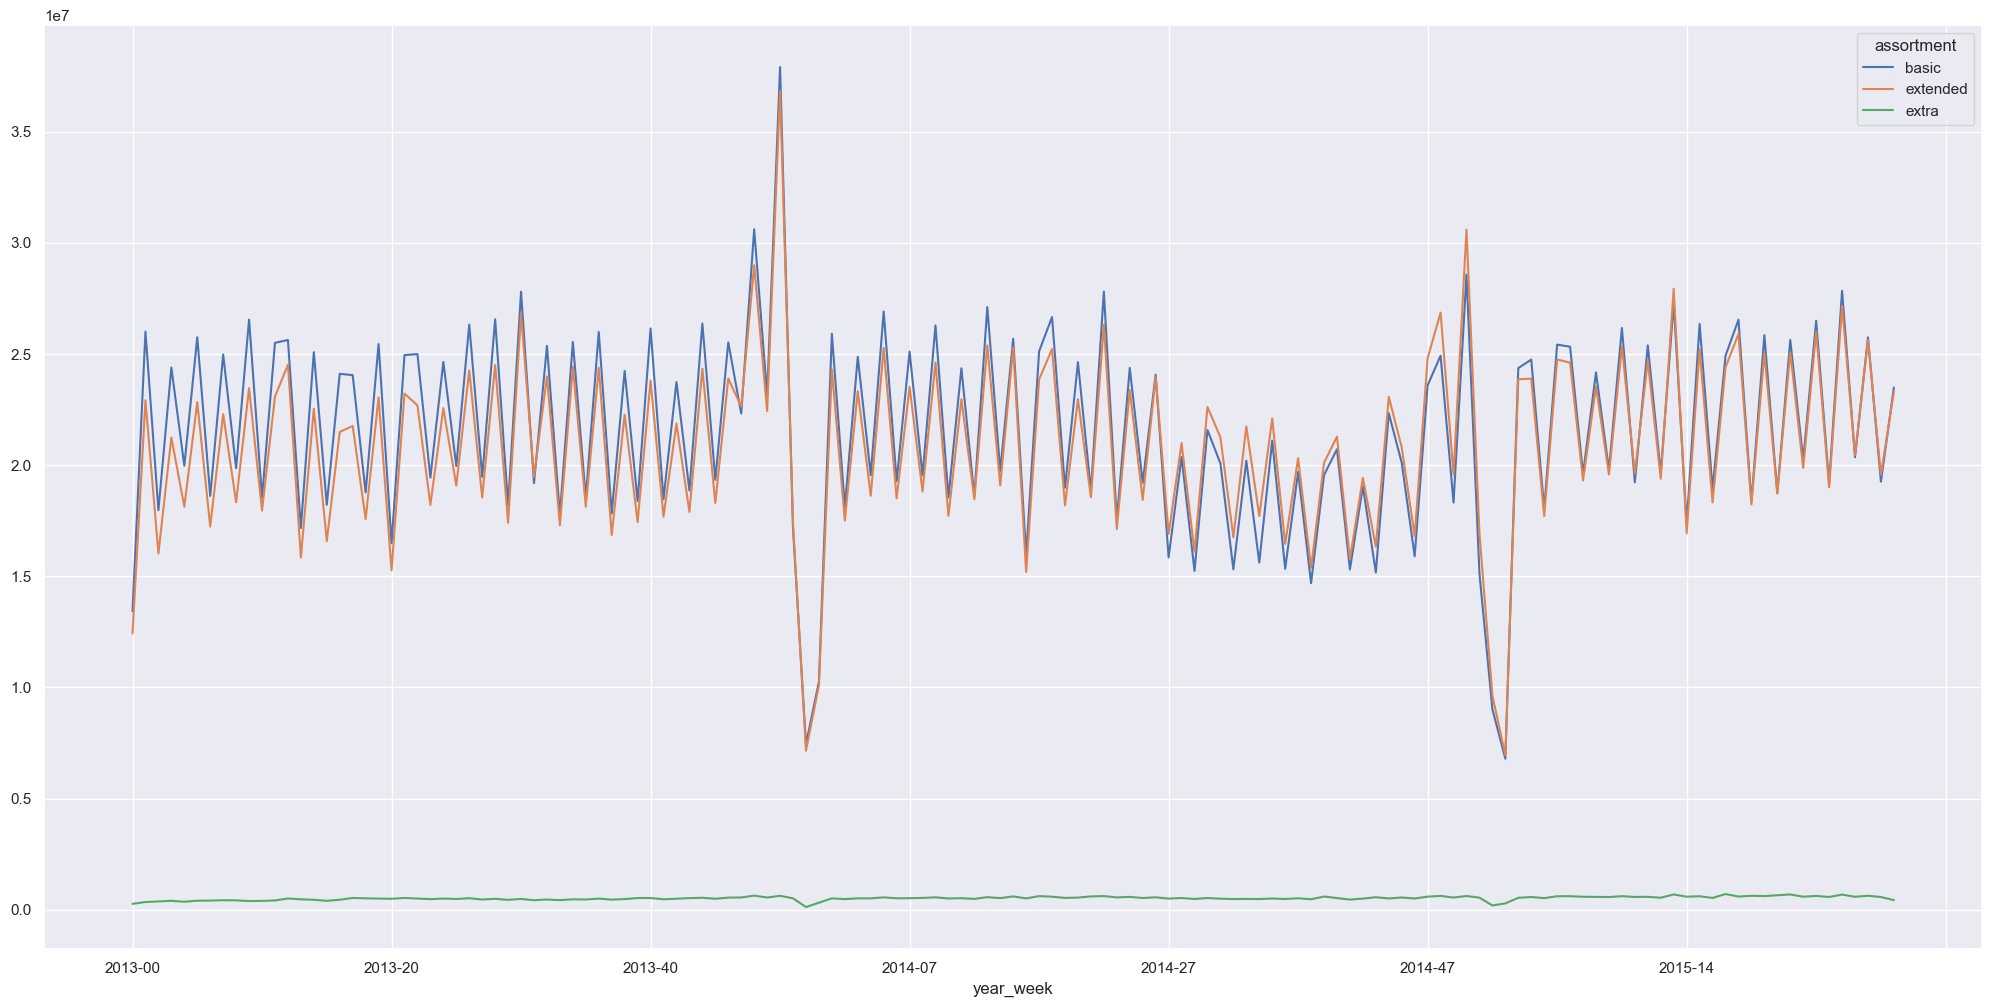

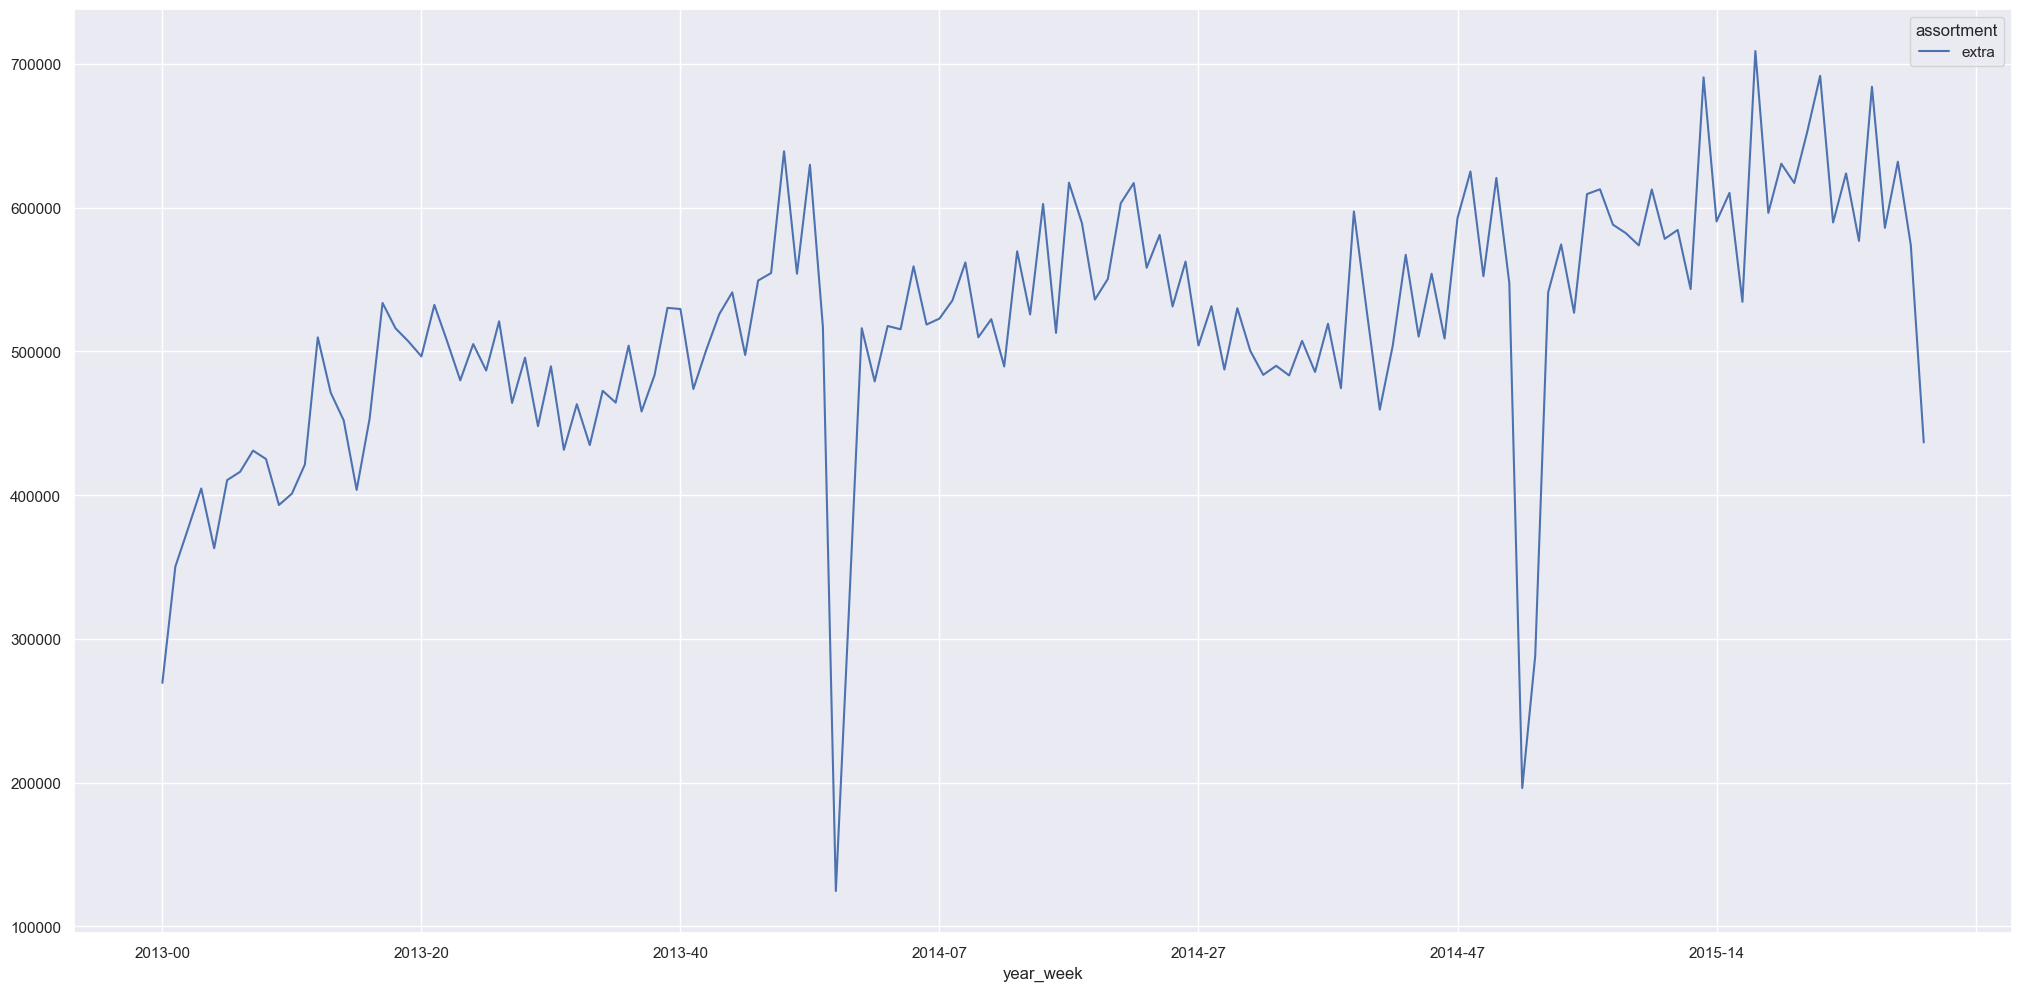

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3  = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot() 

### h2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS. 

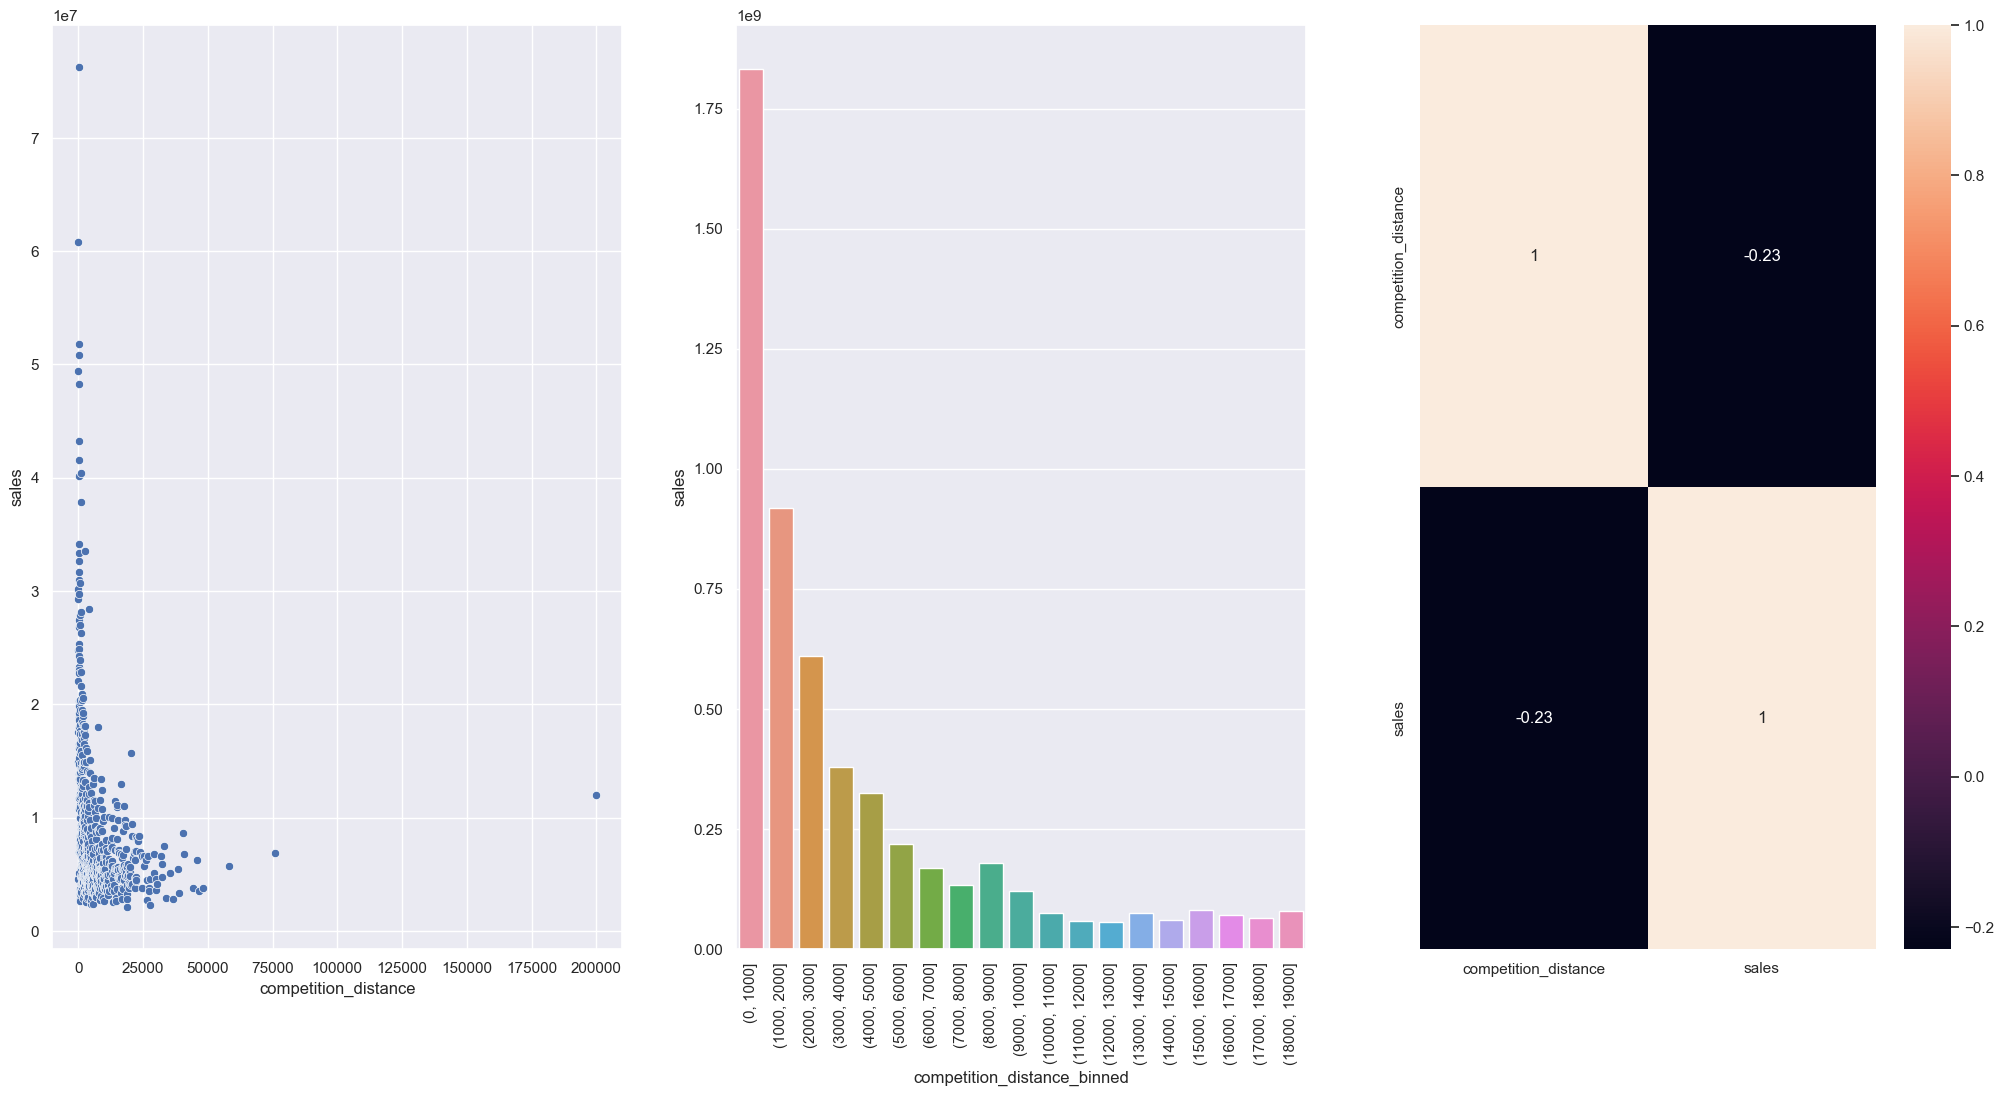

In [22]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index() 

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1); 

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins) 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index() 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2); 
plt.xticks(rotation=90);

plt.subplot(1, 3, 3) 
x = sns.heatmap(aux1.corr(method='pearson'), annot = True); 

### h3. Lojas com competidores à mais tempo vendem mais
**Falsa** : Lojas com competidores a mais tempo vendem menos.

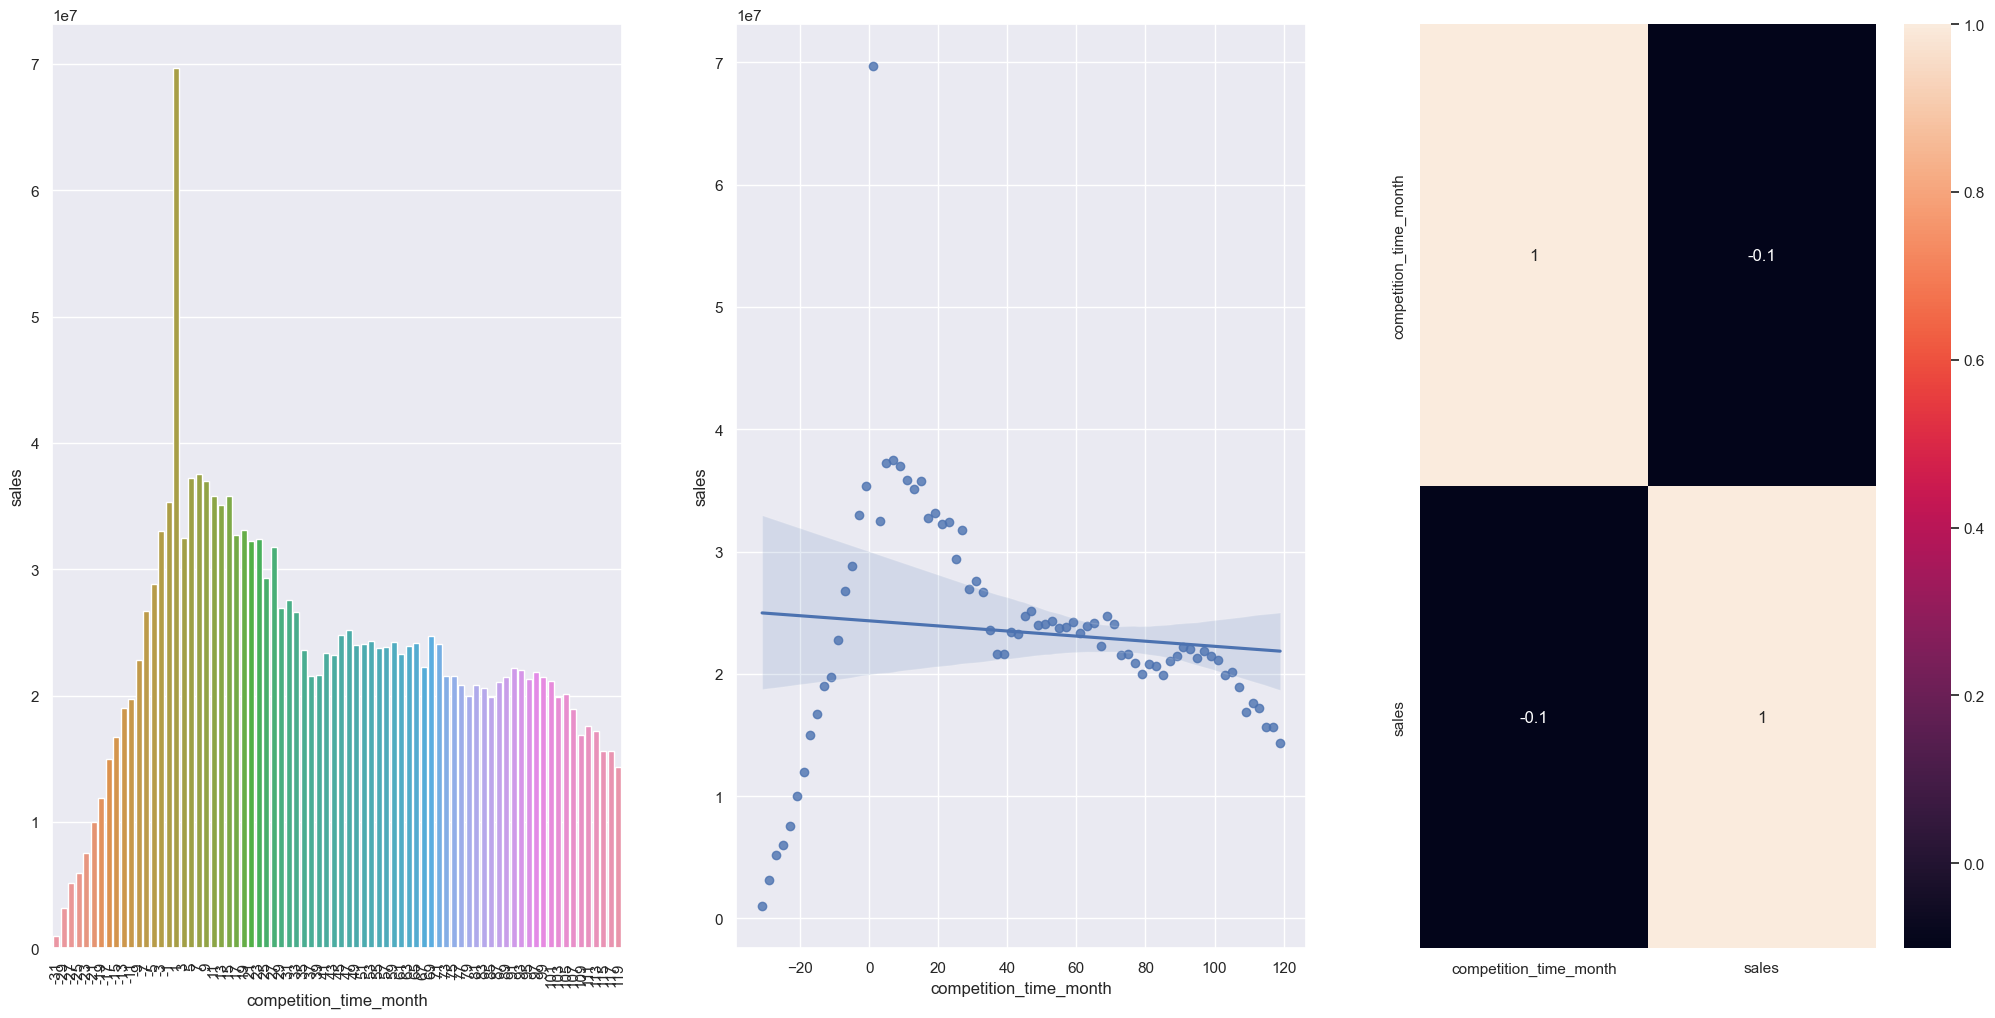

In [78]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & aux1['competition_time_month'] != 0] 
sns.barplot(x ='competition_time_month', y= 'sales', data = aux2); 
plt.xticks(rotation=90);

#OBS: duração negativas referem-se quando o competidor abriu depois da data da compra registrada. Quanto mais se aproxima de zero, maior são as vendas. 

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y ='sales', data = aux2); 

plt.subplot(1, 3, 3) 
x = sns.heatmap(aux1.corr(method='pearson'), annot = True); 

###  H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa**: Pois lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

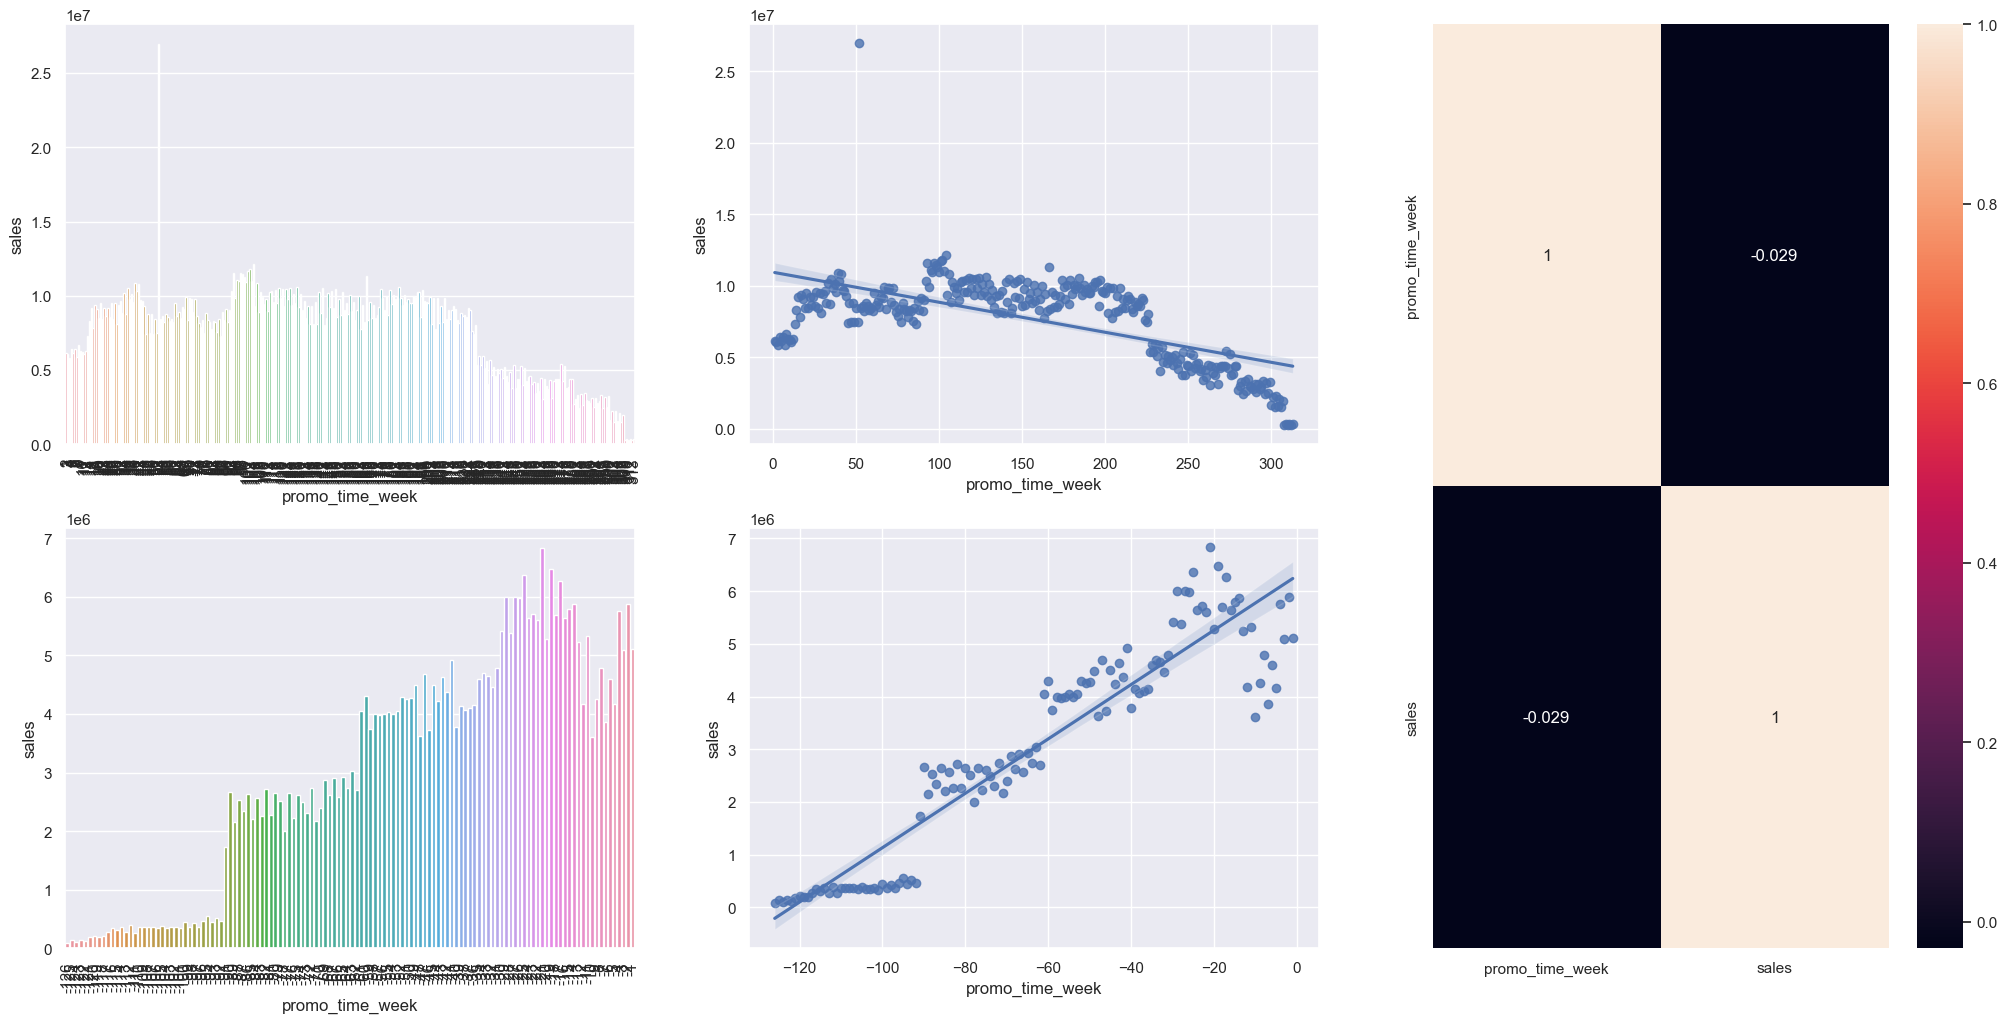

In [77]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

#Divide-se o gráfico em duas partes: promoção extendida e promoção regular. 

#Coluna promo_time_week: 
# Primeiro você tinha o período promocional tradicional e a loja escolhia se entrava no período de promoção extendida ou não. 
# o promo_time_Week pega a diferença entre a data da venda e o a data que começou a promoção extendida da loja. 
# se for positivo estamos na promoção extendida.
# se for negativo, estamos na promoção regular e a data que começará a extendida é uma data futura. 

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo_extendida 
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2); 
plt.xticks(rotation=90); 

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2); 

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular 
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3); 
plt.xticks(rotation=90);

plt.subplot(grid[1, 1]) 
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);  

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True); 

#percebe-se nos gráficos, uma tendência de crescimento, durante a promoção regular, provavelmente fruto do trabalho de marketing que divulga a promoção.
#entretanto, quanto entra-se na promoção extendida, temos uma tendência de decaimento das vendas.

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

###  H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: Lojas com promoções consecutivas vendem menos.

In [25]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


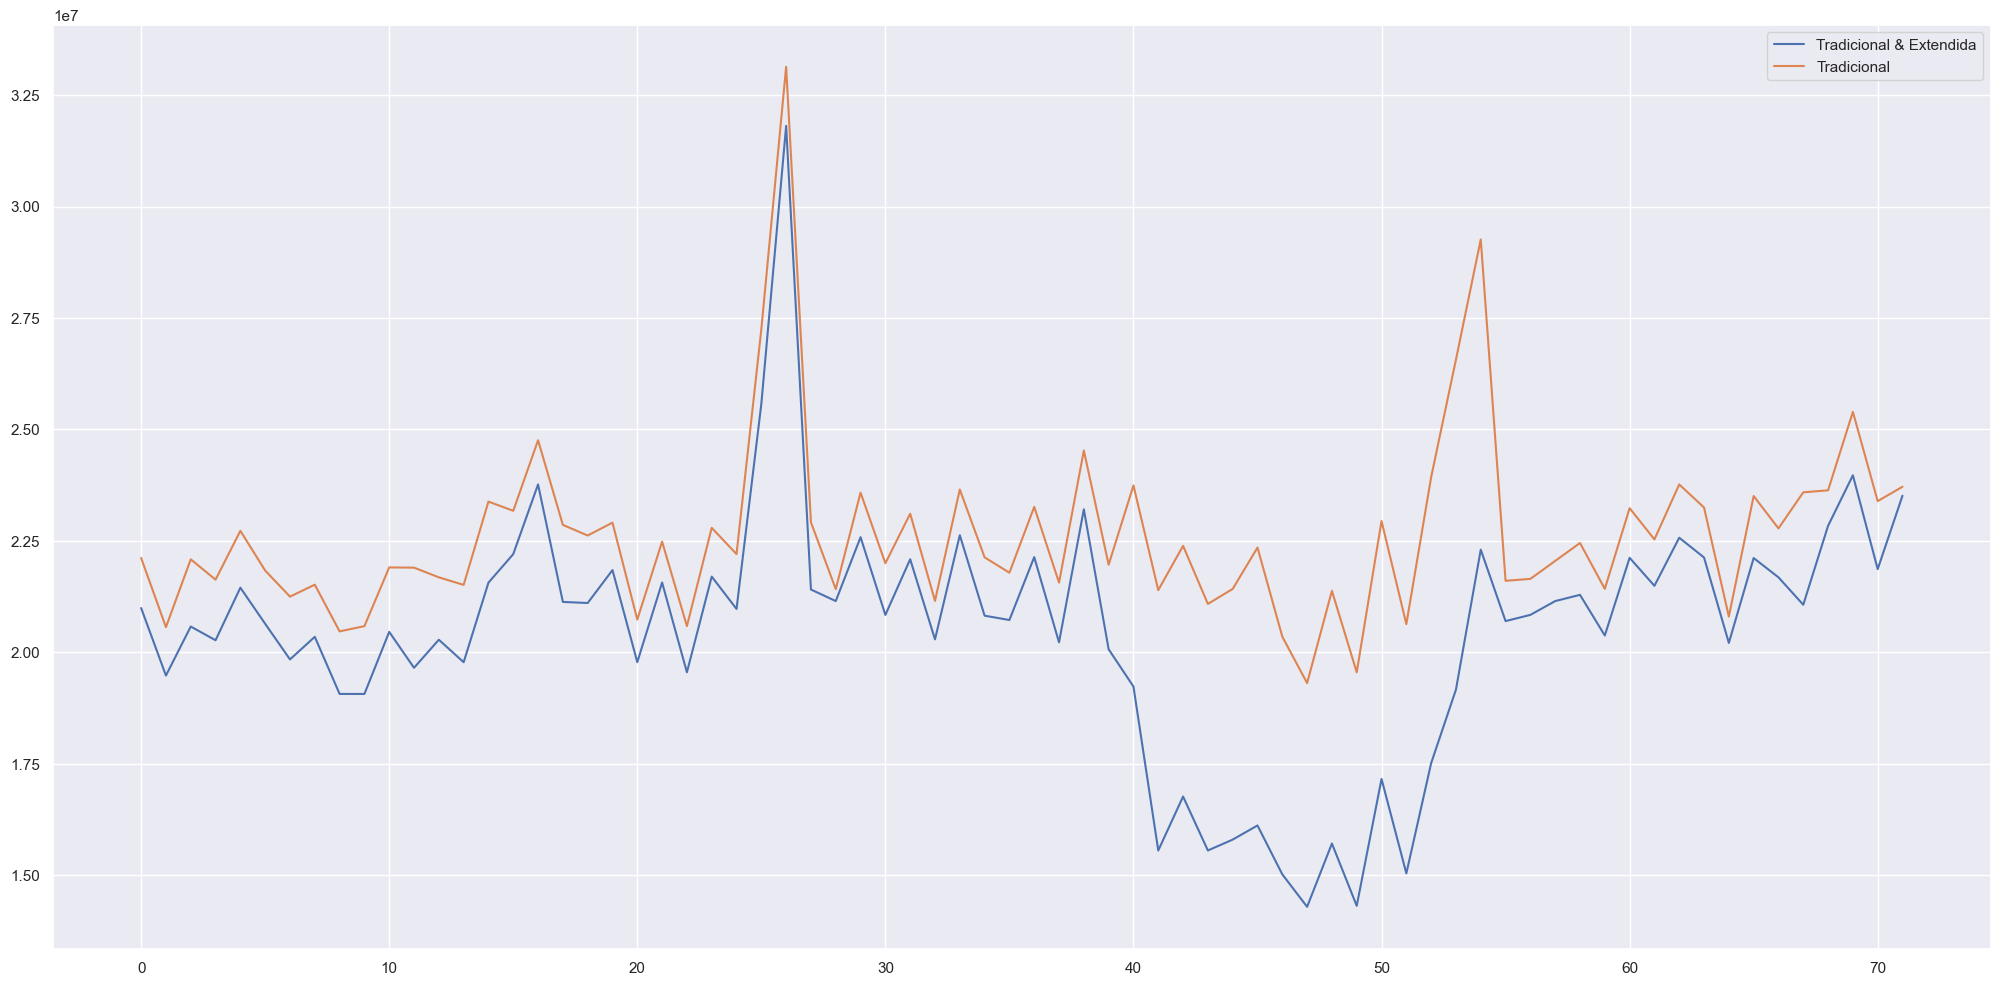

In [28]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot() 

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax) 

ax.legend(labels = ['Tradicional & Extendida', 'Tradicional']); 

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA**: Lojas abertas durante o feriado do natal vendem menos

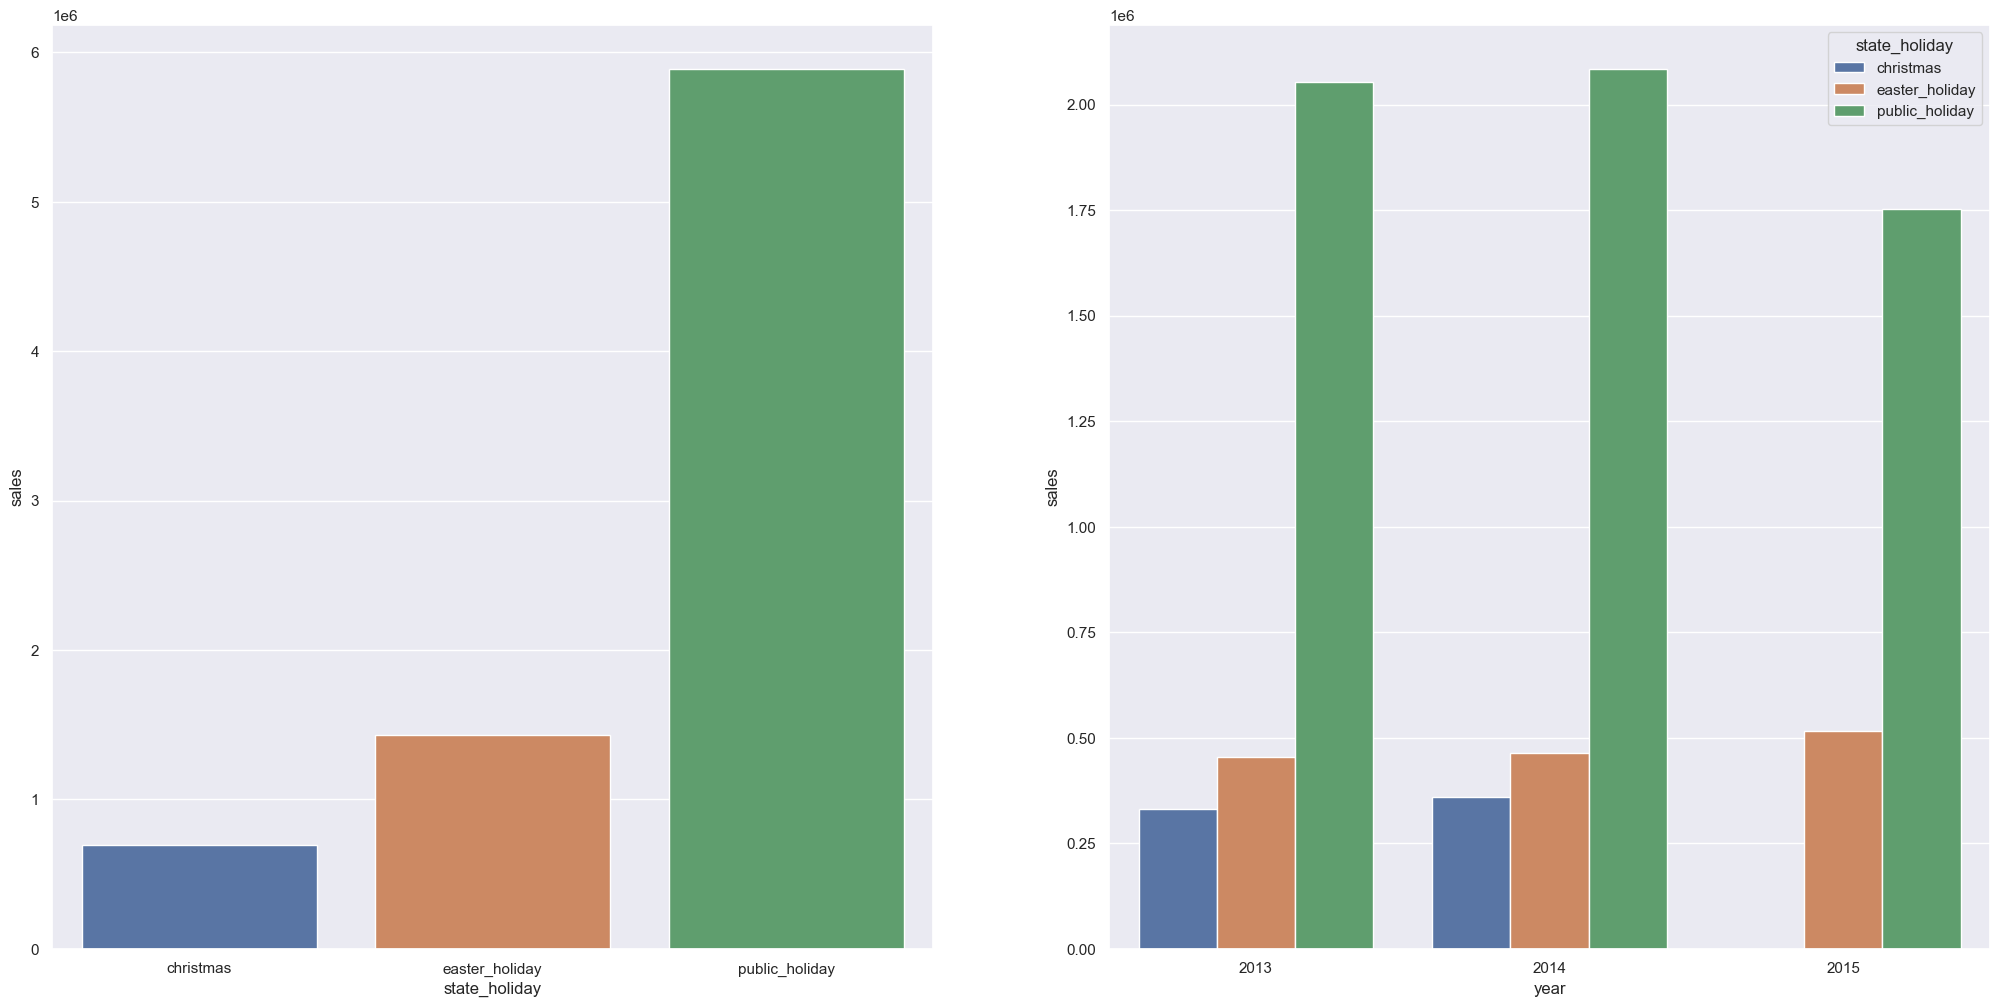

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y = 'sales', data = aux1); 

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index() 
sns.barplot(x='year', y= 'sales', hue = 'state_holiday', data = aux2); 

#OBS: O ano de 2015 vai até agosto. É como se fosse um ano em construção, ele ainda não é fechado. 

In [41]:
aux2

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


### H9 Lojas deveriam vender mais ao longo dos anos.
**Falsa**: Lojas vendem menos ao longo dos anos

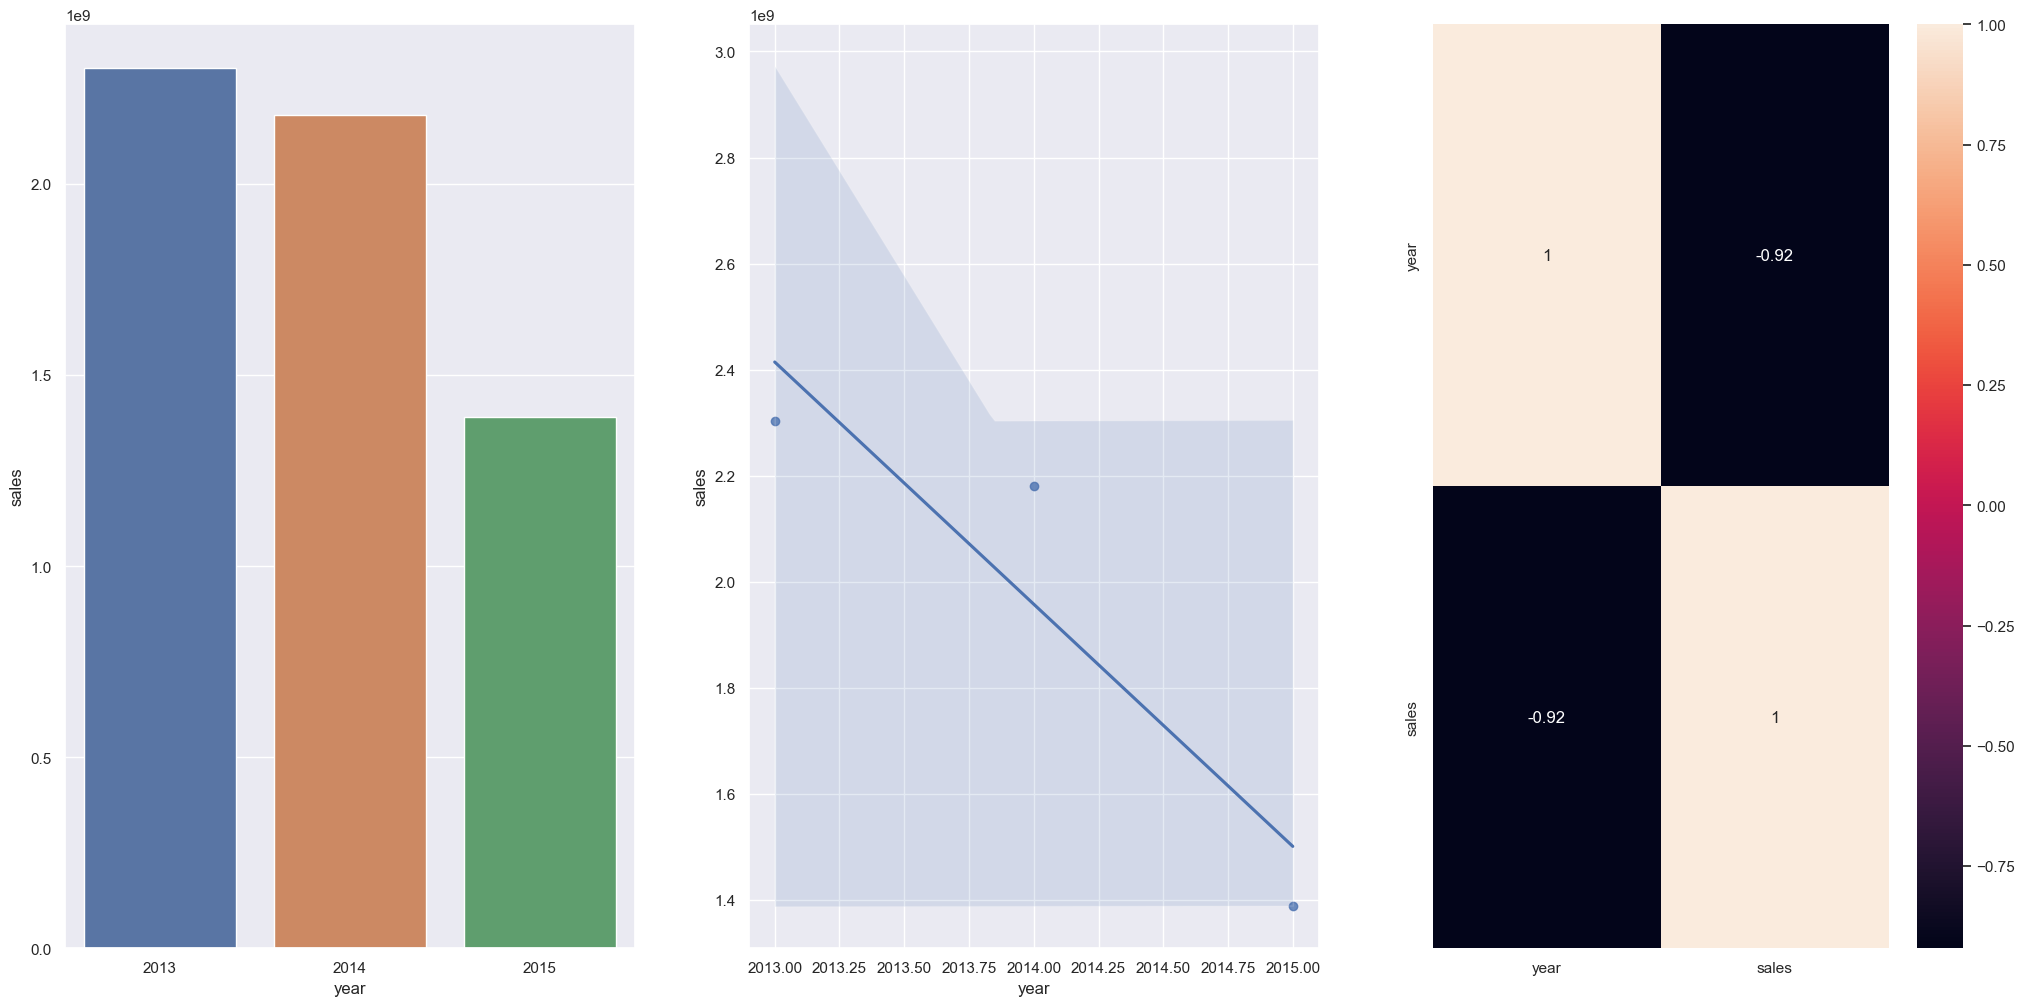

In [44]:
#mostra uma tendência maior de decrescimento porque 2015 não é um ano completo, então é bem menor.

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index() 

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data = aux1); 

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data = aux1); 

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); 

### H10. Lojas deveriam vender mais no segundo semestre do ano.

**Verdadeiro**: Lojas vendem mais no segundo semestre do ano.

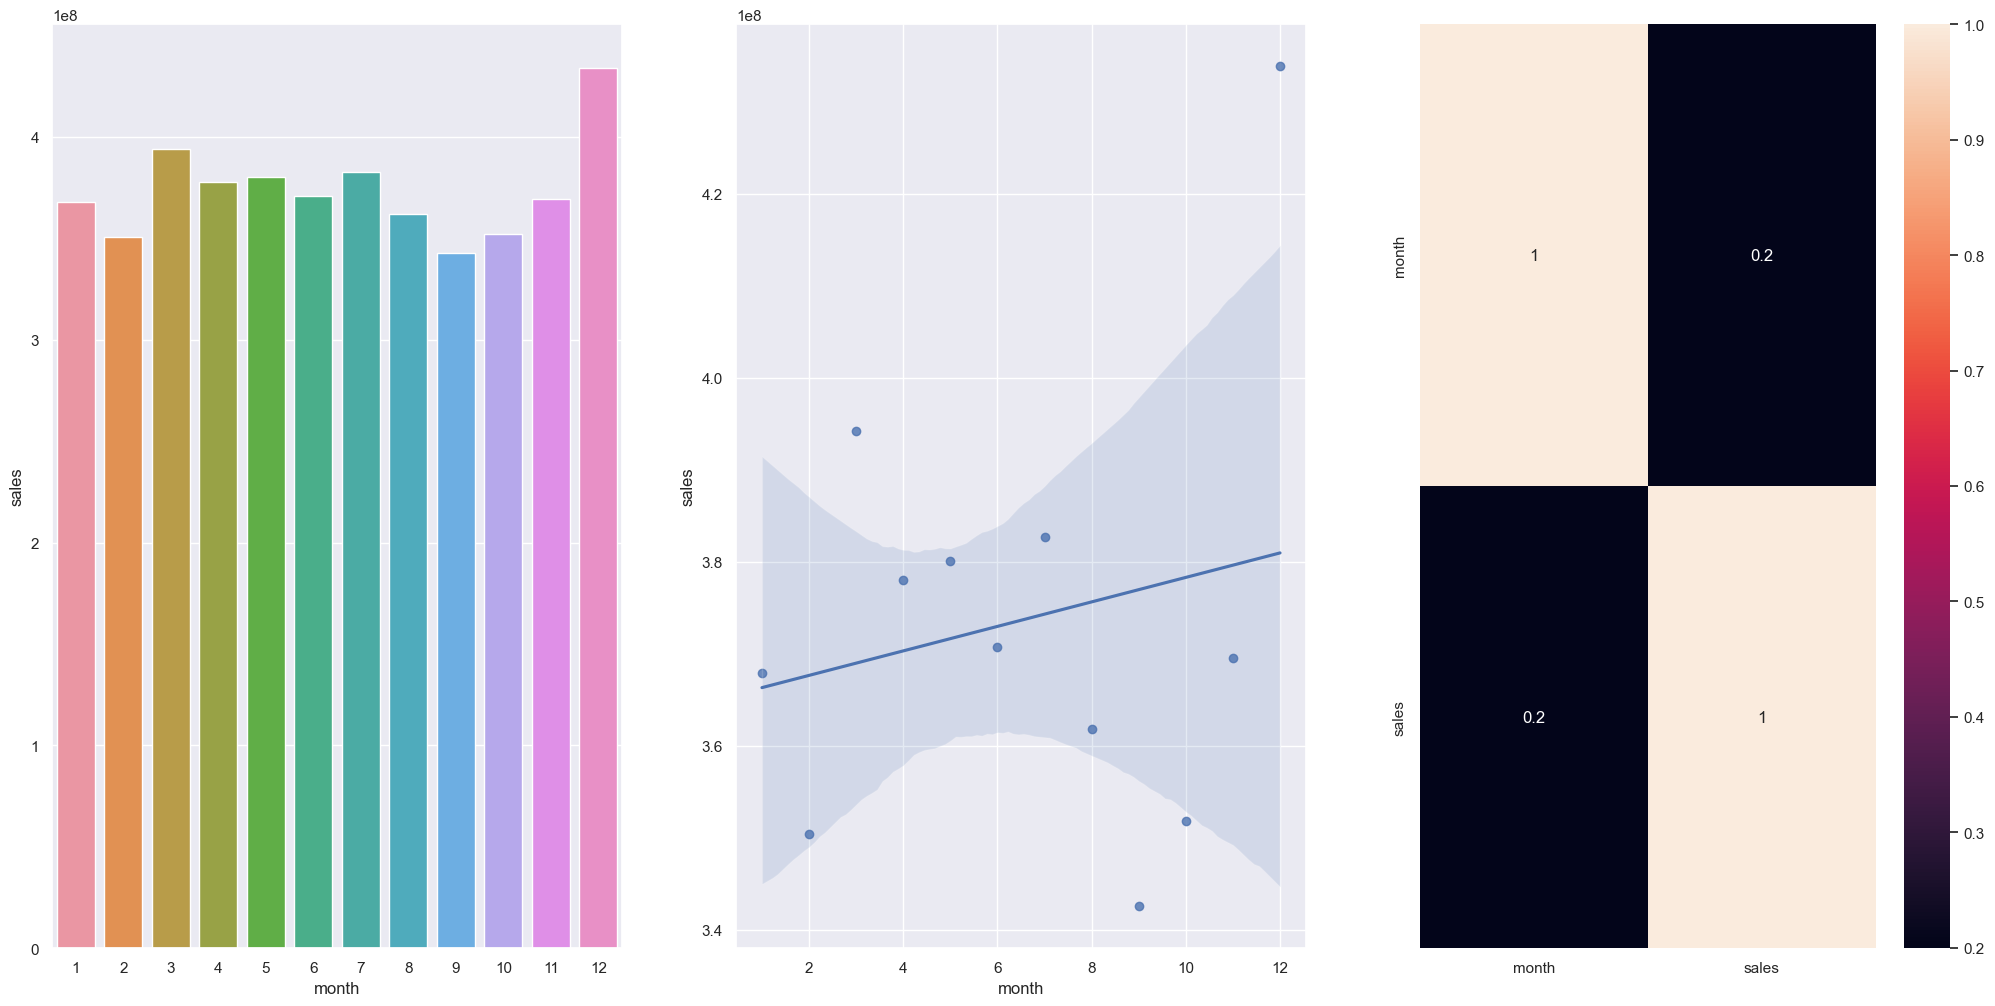

In [49]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index() 

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data = aux1); 

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data = aux1); 

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); 

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO:**: Lojas vendem mais depois do dia 10 de cada mês

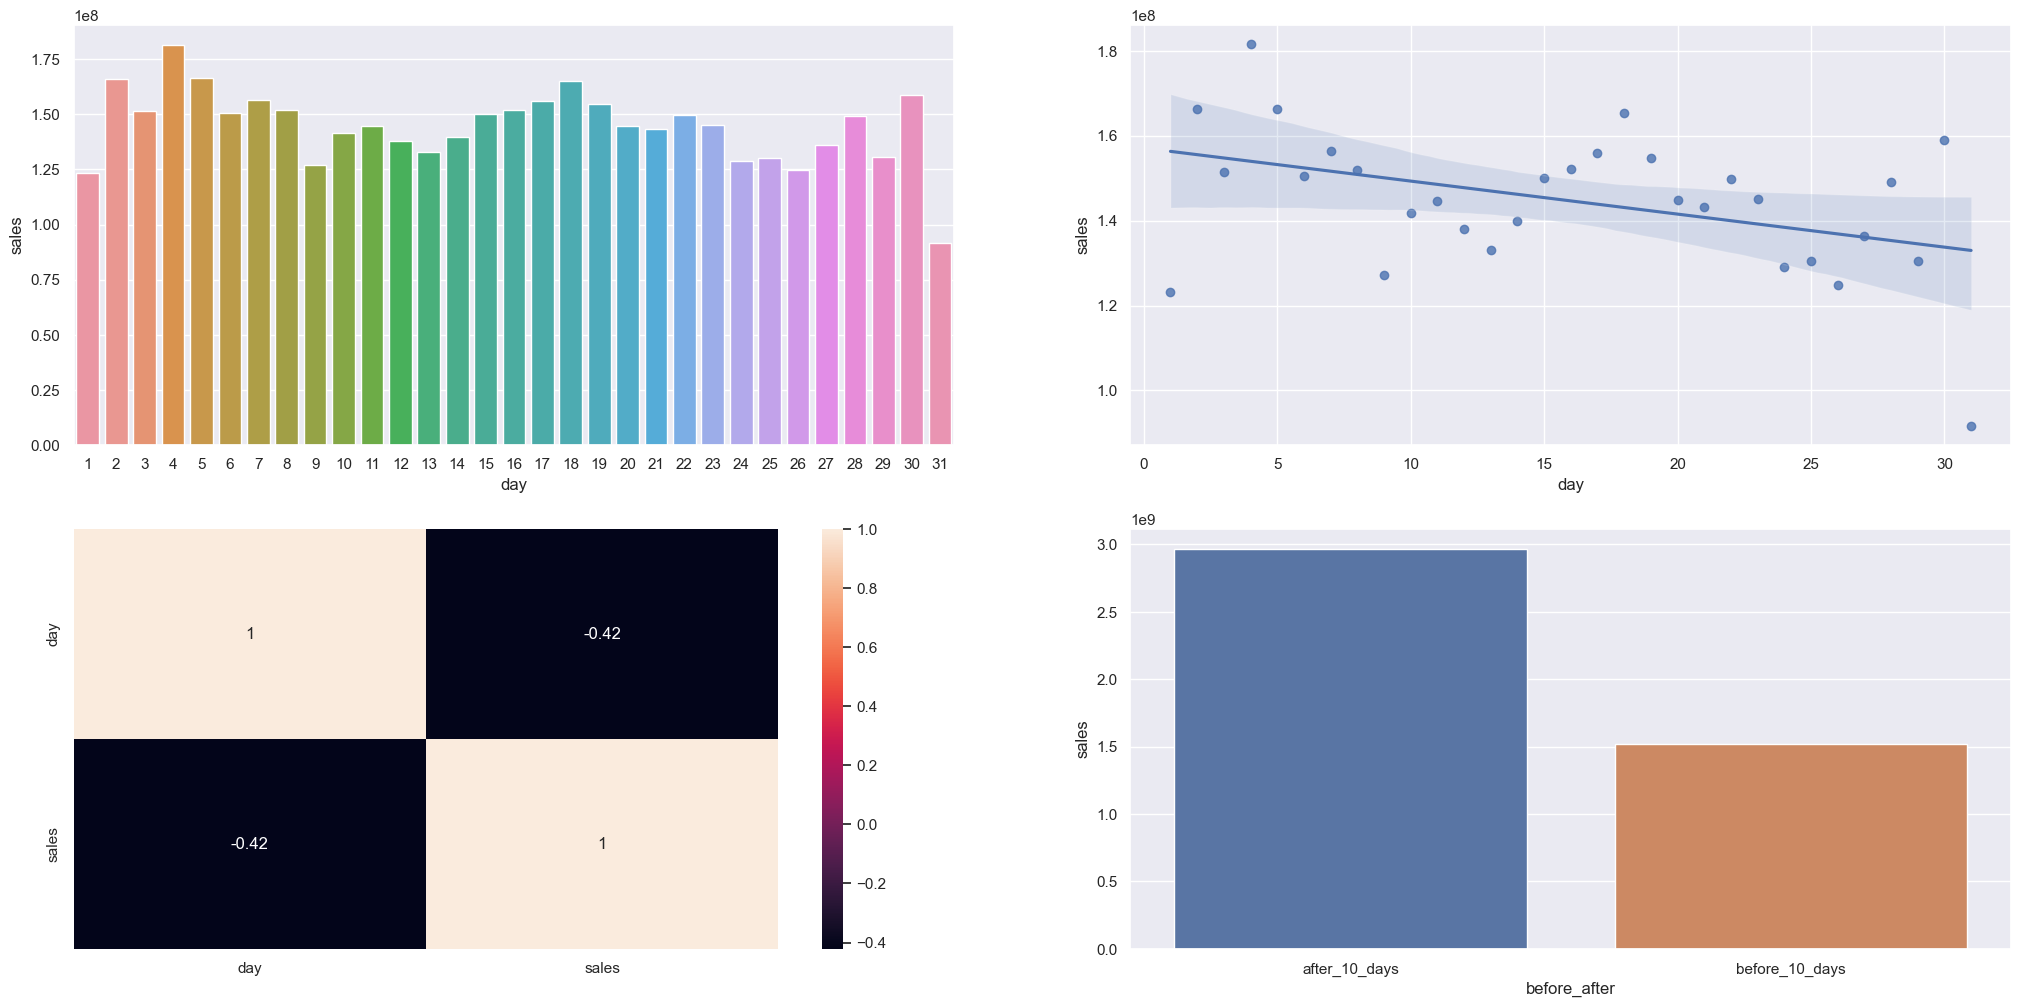

In [52]:
aux1 = aux[['day', 'sales']].groupby('day').sum().reset_index() 

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1); 

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data = aux1); 

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True); 

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days') 
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem menos nos finais de semana


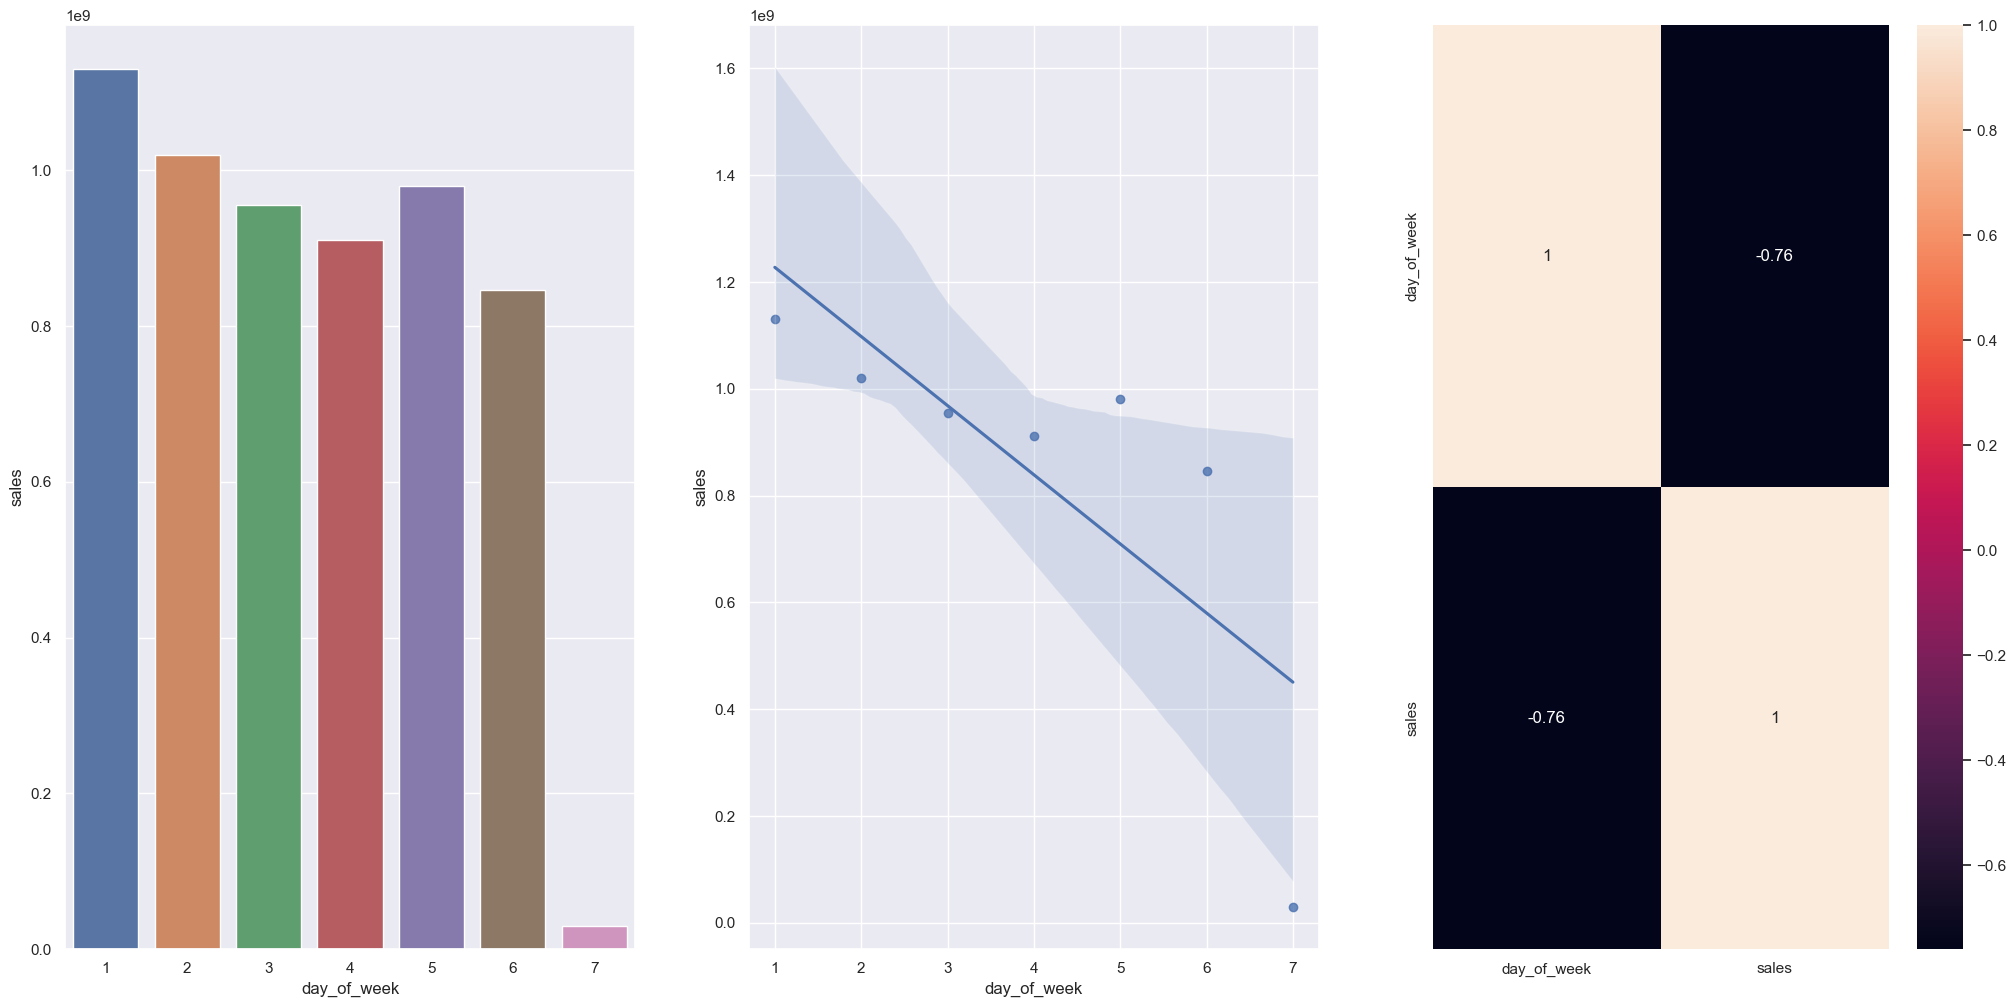

In [53]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index() 

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data = aux1); 

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data = aux1); 

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); 

### H13 Lojas deveriam vender menos durante os feriados escolares
**Verdadeira**: Exceto pelo mês de agosto

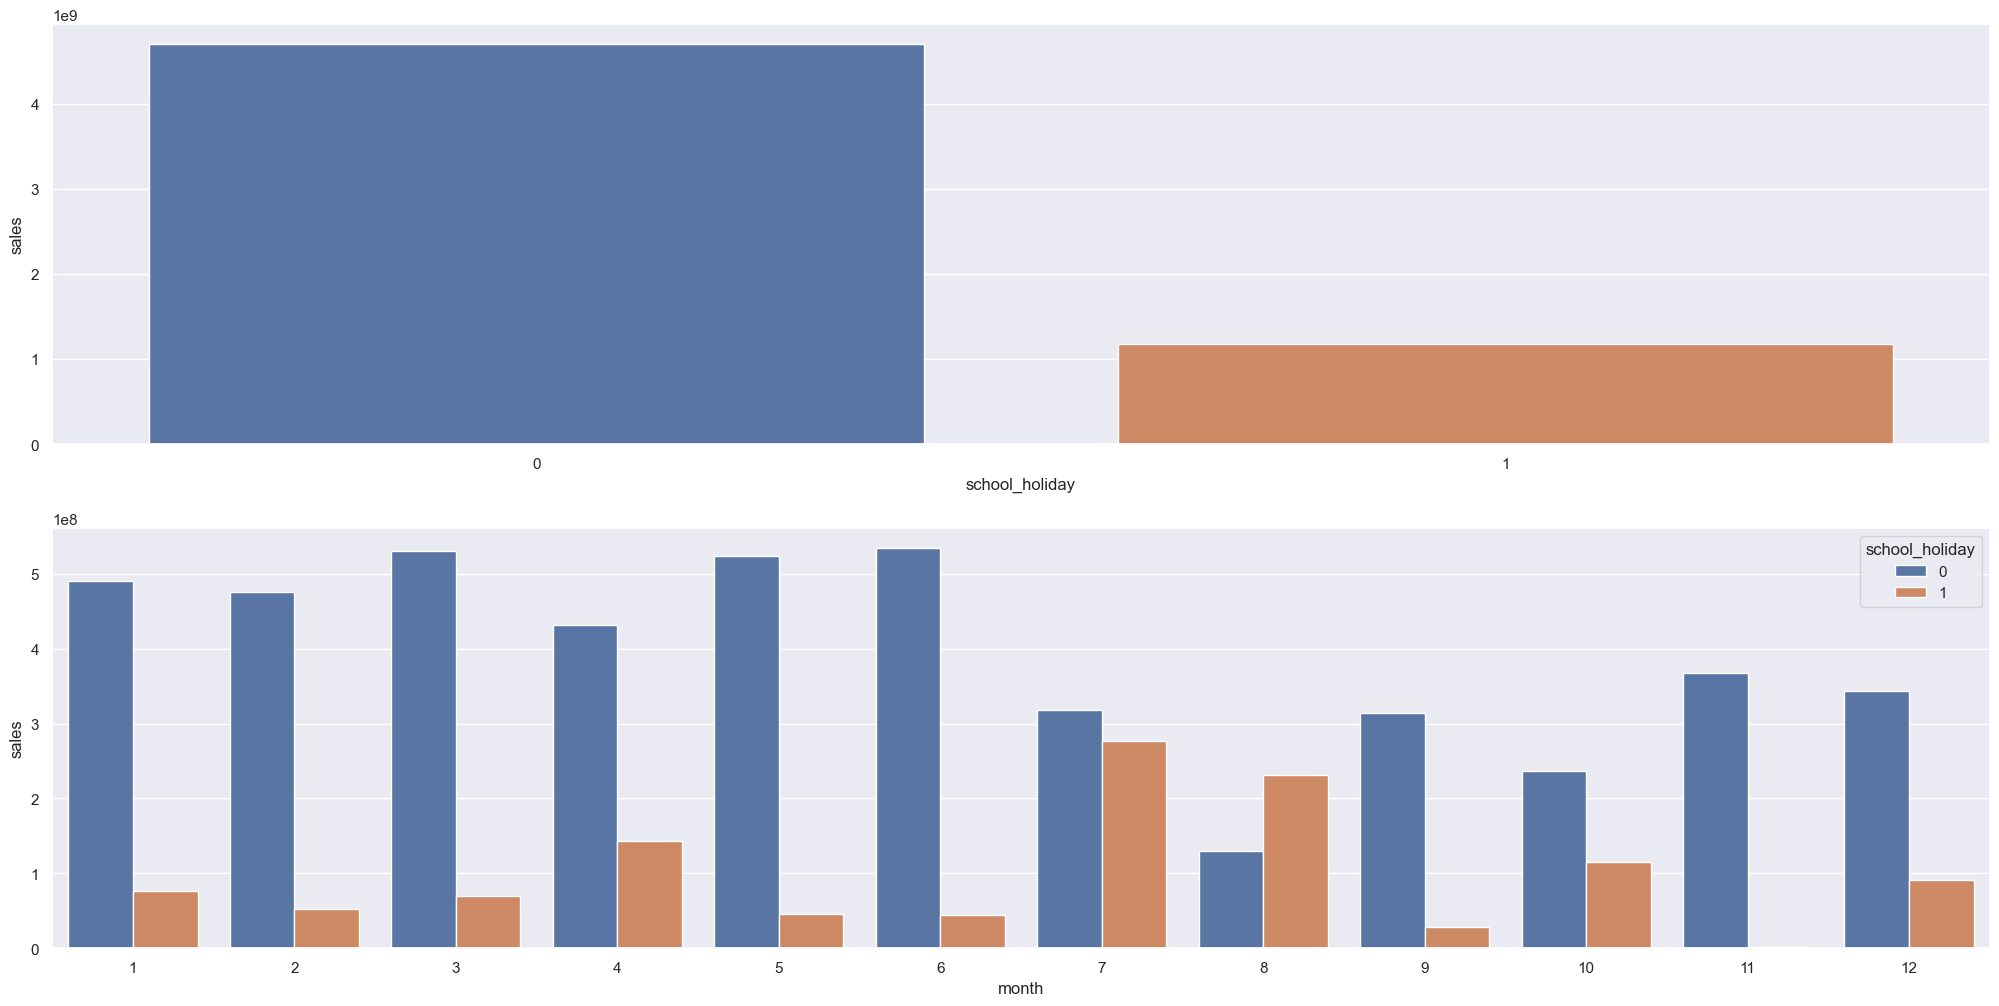

In [54]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

#o mês de julho tem-se um começo de equiparação por conta de ser um mês de férias. 

In [25]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'], 
       ['H1', 'Falsa', 'Media'], 
       ['H3', 'Falsa', 'Media'], 
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', '--', '--'], 
       ['H7', 'Falsa', 'Baixa'], 
       ['H8', 'Falsa', 'Media'], 
       ['H9', 'Falsa', 'Alta'], 
       ['H10', 'Falsa', 'Baixa'], 
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'], 
       ['H13', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers = 'firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H1           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           --           --
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Baixa
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Atributos Numéricos

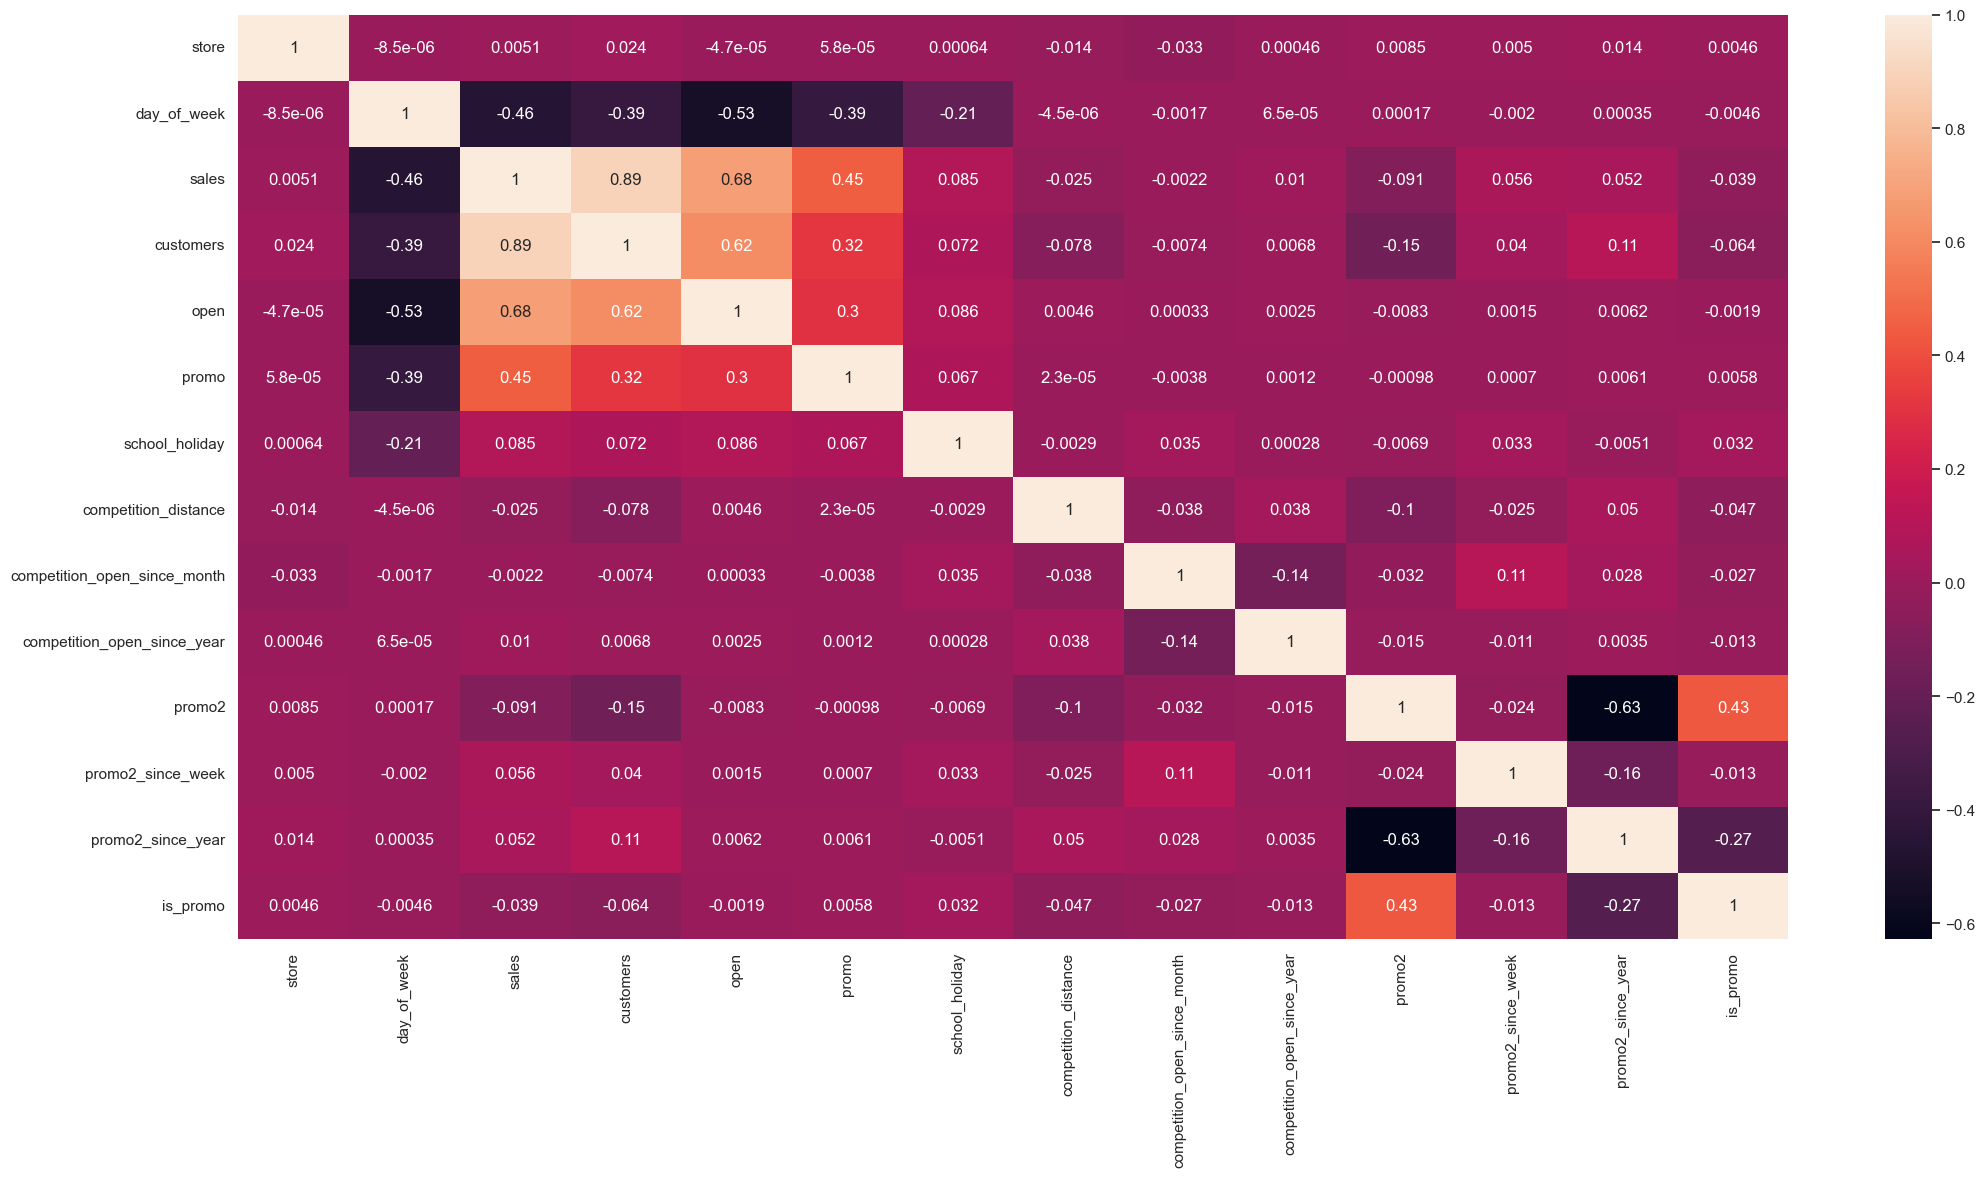

In [249]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True); 

### 4.3.1 Atributos Categóricos

<Axes: >

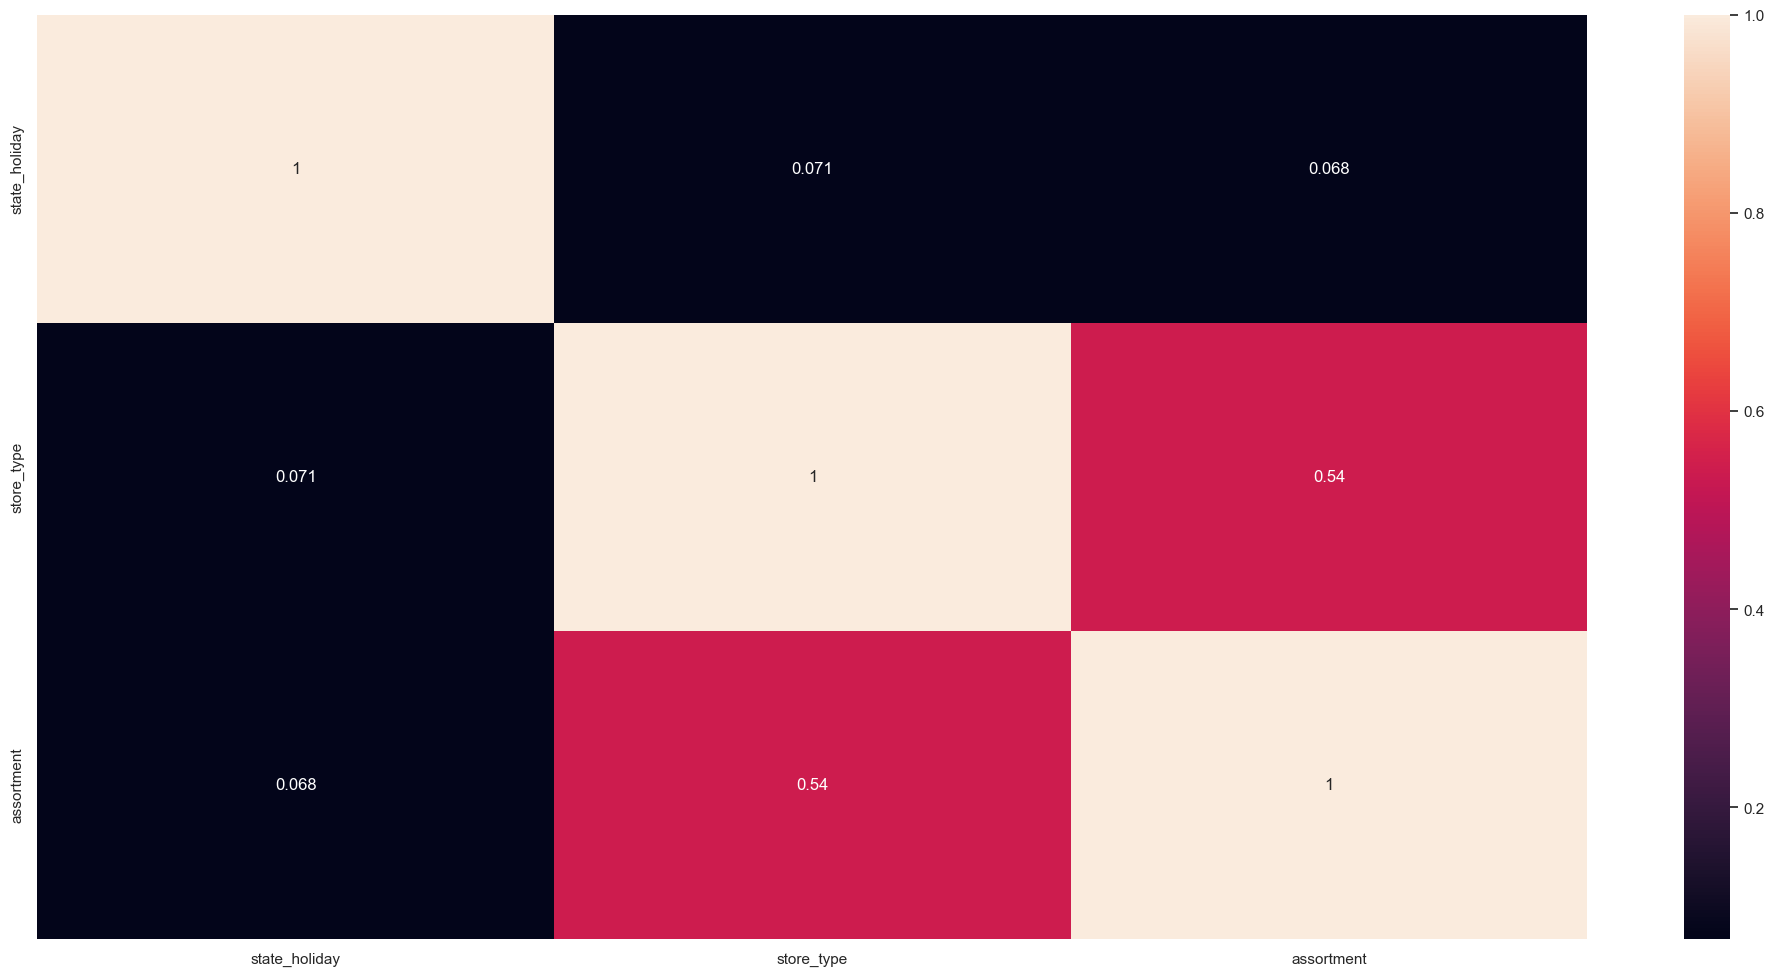

In [32]:
#filtragem de dados categóricos
a = df4.select_dtypes(include = 'object')

#calculando v de cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment']) 

#dataset final 
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
                 'store_type': [a4, a5, a6],
                 'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [60]:
df5 = df4.copy() 

## 5.1 Normalização

In [ ]:
#Como não tem distribuições normais nas variáveis, não será aplicado normalização. 

## 5.2 Rescalling

In [61]:
rs = RobustScaler() 
mms = MinMaxScaler() 

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) #foi verificado alta incidência de outliers utilizando boxplot
pickle.dump(rs, open("parameter\\competition_distance_scaler.pkl", "wb"))


#competition_time_month 
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values) #foi verificada alta incidência de outliers utilizando boxplot 
pickle.dump(rs, open("parameter\\competition_time_month_scaler.pkl", "wb"))


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values) 
pickle.dump(mms, open("parameter\\promo_time_week_scaler.pkl", "wb"))


#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open("parameter\\year_scaler.pkl", "wb"))

## 5.3 Transformação

### 5.3.1 Encoding

In [62]:
#state_holiday - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns = ["state_holiday"])

#store_type - Label Encoding
le = LabelEncoder() 
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open("parameter\\store_type_scaler.pkl", "wb"))

#Assortment - Ordinal Encoding 
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

In [31]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Transformação da Variável Resposta (Transformação de Grandeza)

In [63]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de Natureza

In [64]:
#day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )                                      

#month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )     

#day 

df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )                                      

#week of year 

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )   

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 6 - SELEÇÃO DE ATRIBUTOS

In [66]:
df6 = df5.copy() 

## 6.1 Dividindo dataset entre treino e teste

In [67]:
#deleta-se as variáveis que geraram outras. 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [68]:
# descobrindo a data seis semanas antes da última data registrada. 
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7 * 6) 

Timestamp('2015-06-19 00:00:00')

In [50]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [69]:
#dataset de treino

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] 

X_train['state_holiday_christmas'] = X_train['state_holiday_christmas'].astype('int64')
X_train['state_holiday_easter_holiday'] = X_train['state_holiday_easter_holiday'].astype('int64')
X_train['state_holiday_public_holiday'] = X_train['state_holiday_public_holiday'].astype('int64')
X_train['state_holiday_regular_day'] = X_train['state_holiday_regular_day'].astype('int64')
X_train['store_type'] = X_train['store_type'].astype('int64')

#dataset de teste

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

X_test['state_holiday_christmas'] = X_test['state_holiday_christmas'].astype('int64')
X_test['state_holiday_easter_holiday'] = X_test['state_holiday_easter_holiday'].astype('int64')
X_test['state_holiday_public_holiday'] = X_test['state_holiday_public_holiday'].astype('int64')
X_test['state_holiday_regular_day'] = X_test['state_holiday_regular_day'].astype('int64')
X_test['store_type'] = X_test['store_type'].astype('int64')

print('Data mínima de treino: {}'.format(X_train['date'].min()))
print('Data máxima de treino: {}'.format(X_train['date'].max()))

print('\nData mínima de teste: {}'.format(X_test['date'].min()))
print('Data máxima de teste: {}'.format(X_test['date'].max()))

Data mínima de treino: 2013-01-01 00:00:00
Data máxima de treino: 2015-06-18 00:00:00

Data mínima de teste: 2015-06-19 00:00:00
Data máxima de teste: 2015-07-31 00:00:00


## 6.2 Boruta como um seletor de feature

In [52]:
##dataset de treino e teste para o boruta
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values 
#y_train_n = y_train.values.ravel() #ravel coloca dentro de um vetor 

##definindo RandomForestRegressor

#rf = RandomForestRegressor(n_jobs =-1)
#n_jobs=-1: pra que use todos os cores da máquina e faça todo o processamento de criação de árvores em paralelo e rode mais rápido.

##definindo boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Melhores features a partir do boruta

In [55]:
X_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [160]:
##rank das colunas selecionadas por ordem de relevância
#cols_selected = boruta.support_.to_list() 

##melhores features

#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#não selecionadas
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta )) 

## 6.3. Seleção de Features Manual

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns para adicionar 
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 7 - MODELAGEM COM MACHINE LEARNING 

In [71]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [58]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predição
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions'] 

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) #valores em logaritmo retransformados pelo exponecial. 
baseline_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [39]:
#modelo 
lr = LinearRegression().fit(x_train, y_train) #Treina o modelo e guarda o modelo treinado numa variável chamada lr 

#predição
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) 
lr_result

#Repare que o RSME é muito maior nesse modelo em relação à média
#Isso diz: 
# - A média é mais performática que o modelo de regressão linear
# - O fenômeno é complexo e não pode ser representado por modelos lineares. 

,Model Name,MAE,MAPE,RSME
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model Cross Validation

In [46]:
lr_result_cv = cross_validation(x_training = x_training, kfold = 5, model_name = 'Linear Regression', model = LinearRegression(), verbose = True)


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


In [47]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2088.69+/-291.75,0.3+/-0.02,2961.9+/-463.92


## 7.3 Linear Regression Regularized Model - Lasso

In [48]:
#modelo
lrr = Lasso(alpha = 0.01).fit(x_train, y_train) 

#predição 
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr)) 
lrr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [49]:
model = Lasso(alpha = 0.01)
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', model, verbose = True)


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


In [50]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2123.69+/-337.88,0.29+/-0.01,3068.46+/-499.73


## 7.4. Random Forest Regressor

In [52]:
# modelo 
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train) 

#predição
yhat_rf = rf.predict(x_test)

In [53]:
#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,679.881137,0.099945,1011.628207


### 7.4.1 Random Forest Regressor - Cross Validation

In [54]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,840.93+/-216.49,0.12+/-0.02,1259.41+/-315.89


## 7.5. XGBoost Regressor

In [61]:
# modelo
model_xgb = xgb.XGBRegressor().fit( x_train, y_train )

In [62]:
#predição
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### 7.5.1 XGBoost Regressor - Cross Validation

In [63]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,1069.92+/-177.59,0.15+/-0.02,1526.78+/-240.6


## 7.6. Comparando a Performance dos Modelos

### 7.6.1. Performance Única

In [64]:
modelling_result_cv = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]) 
modelling_result_cv.sort_values('RSME')

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,679.881137,0.099945,1011.628207
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Performance Real - Cross Validation

In [66]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv]) 
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2088.69+/-291.75,0.3+/-0.02,2961.9+/-463.92
0,Lasso,2123.69+/-337.88,0.29+/-0.01,3068.46+/-499.73
0,Random Forest Regressor,840.93+/-216.49,0.12+/-0.02,1259.41+/-315.89
0,XGBoost Regressor,1069.92+/-177.59,0.15+/-0.02,1526.78+/-240.6


# 8.0. PASSO 08 -  HYPERPARAMETER FINE TUNING 

## 8.1 Random Search

In [ ]:
#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500], 
#         'eta': [0.01, 0.03], 
#         'max_depth': [3, 5, 9], 
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9], 
#         'min_child_weight': [3, 8, 15]} 

In [ ]:
#final_result = pd.DataFrame() 
#
#for i in range(MAX_EVAL): 
#    
#    #escolhendo valores para os parâmetros aleatoriamente
#    hp = { k: random.sample(v,1)[0] for k, v in param.items() } 
#    print(hp)
#    
#    #modelo 
#    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = hp['n_estimators'], eta = hp['eta'], max_depth = hp['max_depth'] , 
#                                 subsample = hp['subsample'], colsample_bytree = hp['colsample_bytree'], min_child_weight = hp['min_child_weight'])
#
#    #performance
#    result = cross_validation(x_training, 2, 'XGTBoost Regressor', model_xgb, verbose=False)
#    
#    final_result = pd.concat([final_result, result]) 
#    
#final_result     

## 8.2 Modelo Final 

In [225]:
#forma escolhidos os parâmetros que geram não só o menor erro, mas o que deixa o modelo mais simples possível. 

param_tuned = {'n_estimators': 3000 , 
         'eta':0.03, 
         'max_depth': 5, 
         'subsample': 0.7,
         'colsample_bytree': 0.7, 
         'min_child_weight': 3} 

In [267]:
model_xgb_tuned = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = param_tuned['n_estimators'], eta = param_tuned['eta'], max_depth = param_tuned['max_depth'] , 
                                 subsample = param_tuned['subsample'], colsample_bytree = param_tuned['colsample_bytree'], min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

In [73]:
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

#performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,770.209978,0.115623,1108.062869


In [292]:
pickle.dump(model_xgb_tuned, open('C:\\Users\\Matheus\\Desktop\\pc_comunidade_ds_atualizado_31-01\\ds_em_producao\\model\\model_rossman.plk', 'wb'))

# 9.0. PASSO 9 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [74]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Performance de Negócio

In [75]:
# soma das predições
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordenando colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [72]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


In [88]:
#resultado em valor agregado
dict_aux = {'predictions': round(df92['predictions'].sum(), 2), 'worst_scenario': round(df92['worst_scenario'].sum(), 2), 'best_scenario': round(df92['best_scenario'].sum(),2)}
pd.DataFrame(dict_aux, index = [0])

,predictions,worst_scenario,best_scenario
0,285817920.00,284955855.73,286679971.81


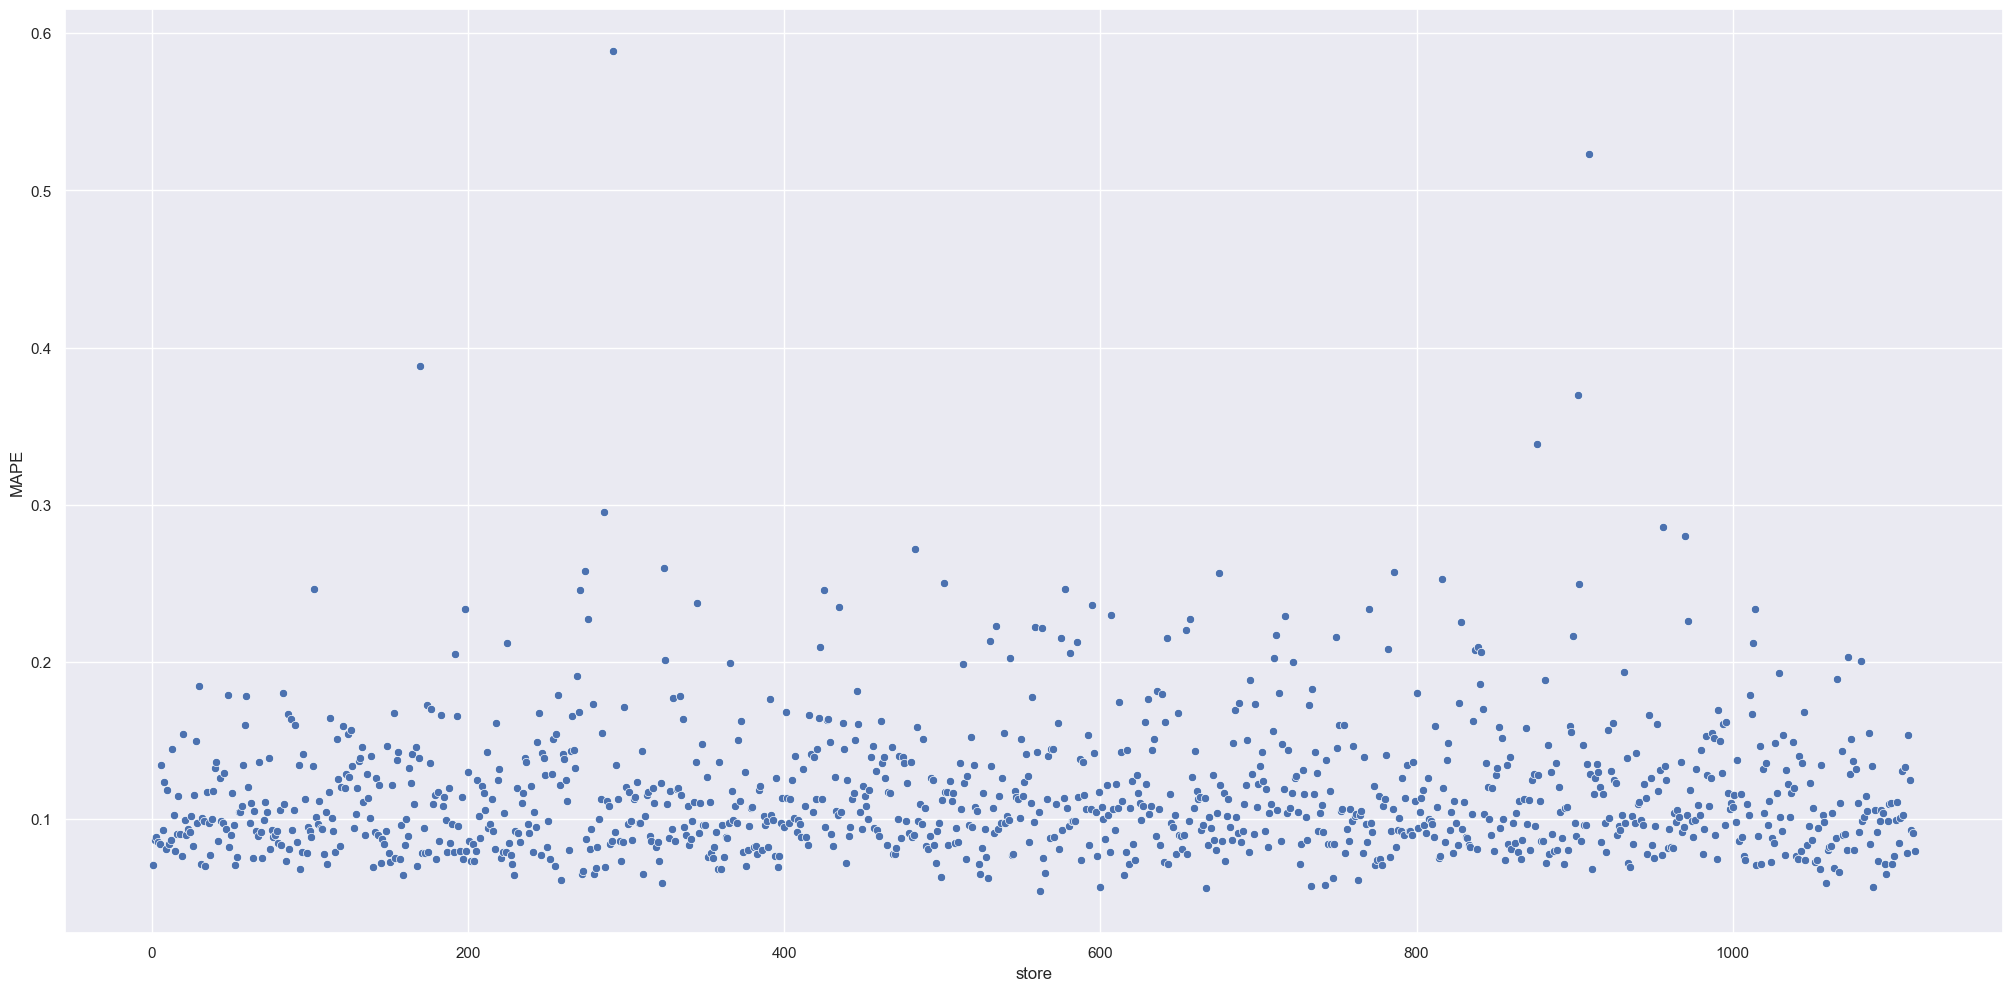

In [73]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2 Performance Total

In [74]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

## 9.3 Performance de Machine Learning

<Axes: xlabel='predictions', ylabel='error'>

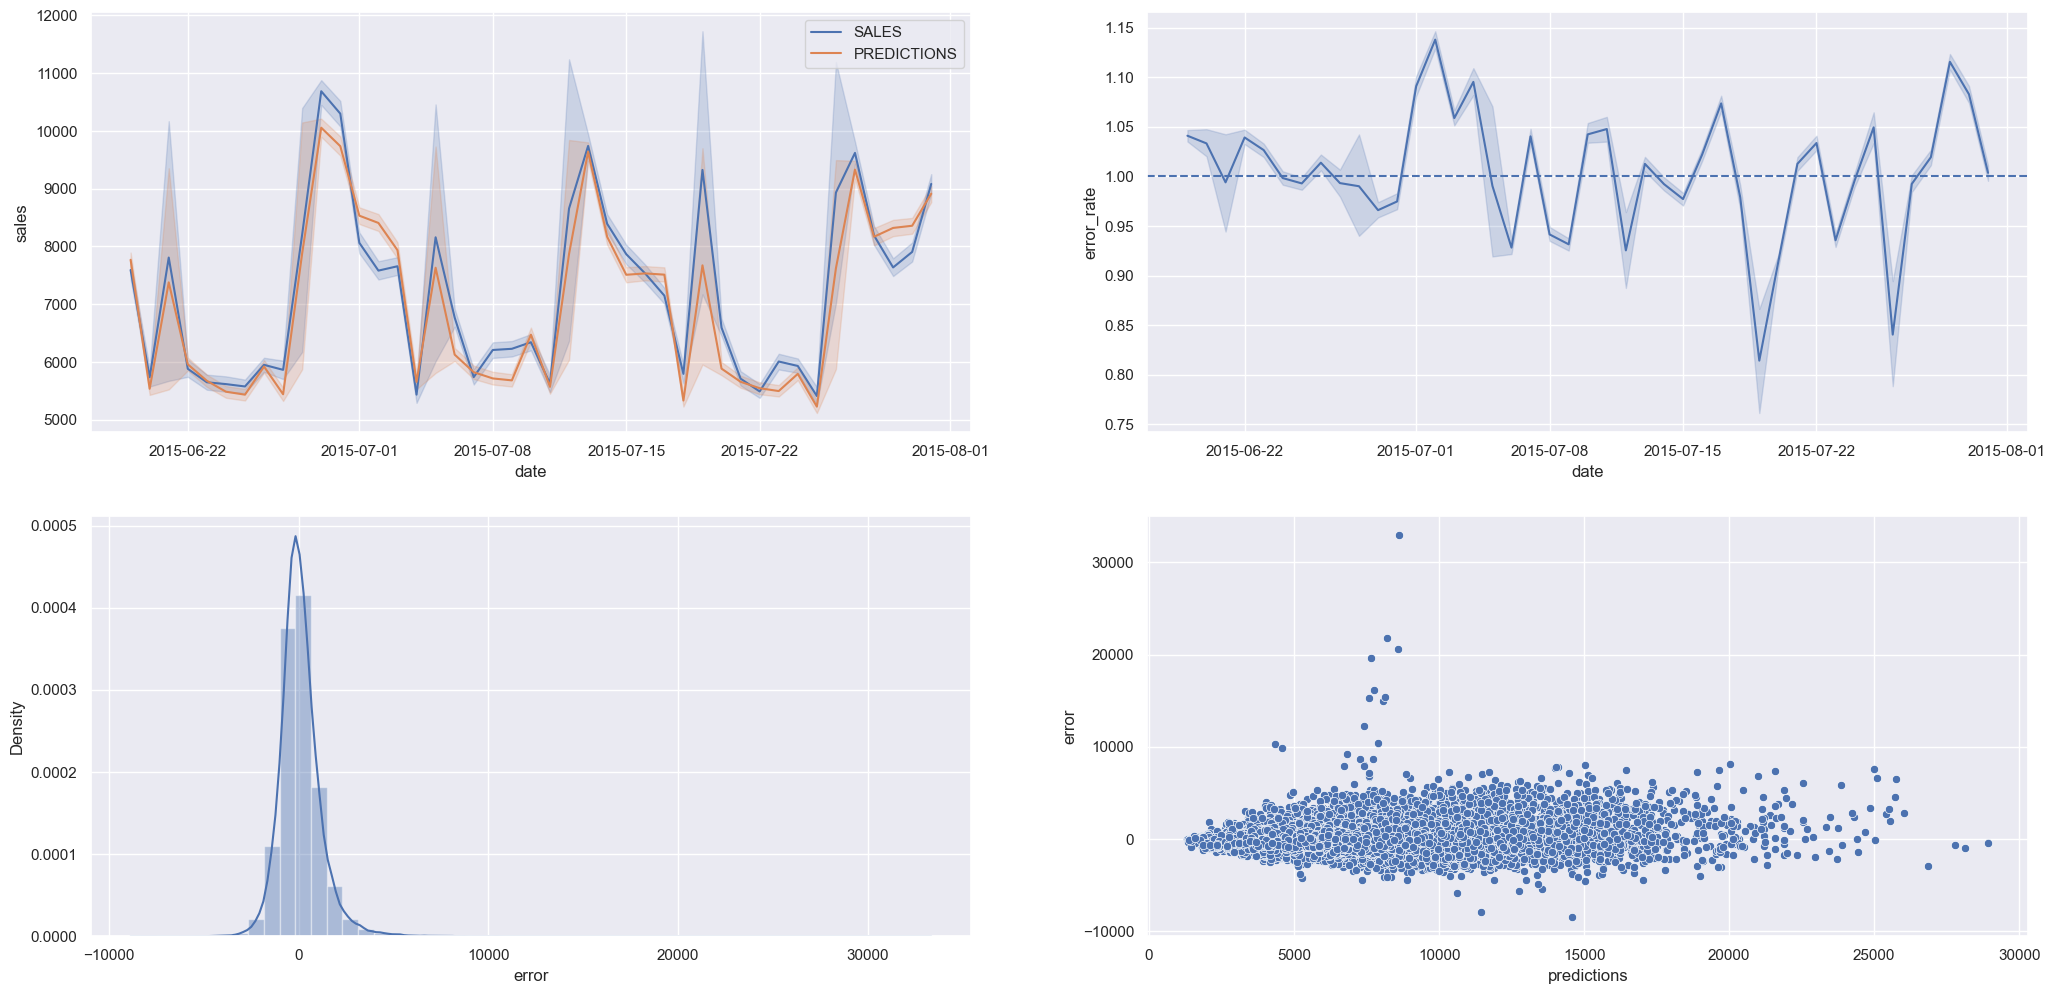

In [299]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x = df9['predictions'], y = df9['error'] )

# 10.0. PASSO 10 - DEPLOY DO MODELO PARA PRODUÇÃO

## 10.1. Rossman Class

In [71]:
import pickle 
import inflection 
import pandas as pd 
import numpy as np 
import datetime 
import math

class Rossmann(object):

    def __init__( self ):
        self.home_path = "C:\\Users\\Matheus\\repos\\Store_Sales_Prediction\\"
        self.competition_distance_scaler = pickle.load(open(self.home_path + "parameter\\competition_distance_scaler.pkl", "rb"))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + "parameter\\competition_time_month_scaler.pkl", "rb"))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + "parameter\\promo_time_week_scaler.pkl", "rb"))
        self.year_scaler = pickle.load(open(self.home_path + "parameter\\year_scaler.pkl", "rb"))
        self.store_type_scaler = pickle.load(open(self.home_path + "parameter\\store_type_scaler.pkl", "rb"))


    def data_cleaning(self, df1):
    
        #1.1 Renomeando Colunas

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'] 

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        # 1.3 Tipo de Dados

        df1['date'] = pd.to_datetime(df1['date'])

        # 1.5 Preenchendo valores NA 

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1) 

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ## 1.6 Trocando Tipos 

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1 
    
    def feature_engineering(self, df2): 

        #ano
        df2['year'] = df2['date'].dt.year 

        #mês
        df2['month'] = df2['date'].dt.month

        #dia 
        df2['day'] = df2['date'].dt.day 

        #semana do ano 
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #semana-ano
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competição desde
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int) 

        #promo desde
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int ) 
        
        #classificação
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #feriado estadual 
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1 Filtragem de linhas

        df2 = df2[(df2['open'] != 0)] 

        ## 3.2 Seleção das Colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2 

    def data_preparation(self, df5): 
        ## 5.1 Normalização

        #Como não tem distribuições normais nas variáveis, não será aplicado normalização. 

        ## 5.2 Rescalling 

        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values) #foi verificado alta incidência de outliers utilizando boxplot

        #competition time month 
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values) #foi verificada alta incidência de outliers utilizando boxplot 

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values) #poucos outliers, dá pra ir 

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformação

        ### 5.3.1 Encoding

        #state_holiday - One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #Assortment - Ordinal Encoding 
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3 Transformação de Natureza

        #day_of_week

        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )                                      

        #month

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )     

        #day 

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )                                      

        #week of year 

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )   

        cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year','promo2', 
                            'promo2_since_week','promo2_since_year', 'competition_time_month', 'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin',
                            'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected_boruta]
    
    def get_prediction(self, model, original_data, test_data): 
        #prediction 
        pred = model.predict(test_data)
        
        #unindo pred em original_data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format = 'iso') 

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Carregando modelo
model = pickle.load( open("C:\\Users\\Matheus\\repos\\Store_Sales_Prediction\\model\\model_rossman.plk", "rb") )
# Inicializando API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: 
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: 
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instanciando Classe Rossmann
        pipeline = Rossmann()
        
        # Limpeza de dados
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # preparação de dados
        df3 = pipeline.data_preparation( df2 )
        
        # predição
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
               
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3 Testando API

In [7]:
#mesclar test dataset + store

df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# escolhendo loja para predição
df_test = df_test[df_test['Store'].isin([24, 12, 22]) ]

#removendo dias de lojas fechadas 
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] 
df_test = df_test.drop('Id', axis = 1 )

In [8]:
#convertendo Dataframe para json
data = json.dumps(df_test.to_dict(orient='records'))

In [9]:
#Chamada na API 

url = 'https://rossmann-sales-prediction-a2rd.onrender.com/rossmann/predict' #endpoint

header =  {'Content-type': 'application/json'} 
data = data 

r = requests.post(url, data=data, headers = header ) 

Status Code 200


In [10]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)): 
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'], 
        d2.loc[i, 'prediction'] )) 

Store Number 12 will sell R$236,873.84 in the next 6 weeks
Store Number 22 will sell R$147,884.48 in the next 6 weeks
Store Number 24 will sell R$323,431.98 in the next 6 weeks


In [70]:
str(r)

'<Response [500]>'